# Model Development, Evaluation & Optimization

#### Deep Learning NLP Models for Sentiment Classification

<div style="background-color: #000000ff; padding: 20px; border-left: 5px solid #2196F3; margin: 20px 0;"> <h3>🎯 <strong>Notebook:</strong> 03_model_development_evaluation_optimization.ipynb</h3> <h3>📊 <strong>Objective:</strong> Develop and evaluate deep learning models for sentiment analysis</h3> <h3>🚀 <strong>Target:</strong> Achieve 85-93% accuracy with neural architectures</h3> <h3>📈 <strong>Baseline:</strong> 78.88% (TF-IDF + Logistic Regression from Step 4B)</h3> </div>

📋 Model Development Strategy
Progressive Architecture Complexity
We'll build models in increasing sophistication:


- Simple LSTM (Sequential understanding)

- Bidirectional LSTM (Context from both directions)

- LSTM + Attention (Focus mechanism)

- CNN-LSTM Hybrid (Local + sequential patterns)

- Transformer-style attention

#### Cell 1: Environment Setup

In [1]:
"""
VelociSense Analytics - Model Development Notebook
===================================================
Notebook: 03_model_development_evaluation_optimization.ipynb
Purpose: Deep Learning NLP models for sentiment classification
Author: [Your Name]
Date: November 2025
"""

# Core libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Deep learning frameworks
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Scikit-learn utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    f1_score, precision_score, recall_score, roc_auc_score, roc_curve
)

# Word embeddings
from gensim.models import Word2Vec
import gensim.downloader as api

# Utilities
from tqdm import tqdm
import time
import json
import pickle

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Check GPU availability
print("🔧 ENVIRONMENT SETUP")
print("="*50)
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")
print(f"Keras version: {keras.__version__}")
print("✅ Environment configured successfully!")

2025-11-15 22:47:52.869389: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-15 22:47:52.965940: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-15 22:47:52.999697: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-15 22:47:53.108222: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-15 22:47:55.075542: W tensorflow/compiler/tf2

🔧 ENVIRONMENT SETUP
TensorFlow version: 2.17.1
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Keras version: 3.11.3
✅ Environment configured successfully!


I0000 00:00:1763227077.487910  114830 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1763227078.241890  114830 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1763227078.242221  114830 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
print("\n📂 LOADING PROCESSED DATASET")
print("="*50)

# Load final processed data from Step 5
try:
    df = pd.read_csv('processed_data/sentiment140_final_processed.csv')
    
    print(f"✅ Dataset loaded successfully")
    print(f"   Records: {len(df):,}")
    print(f"   Columns: {df.columns.tolist()}")
    
    # Reconstruct tokens from string format
    df['tokens'] = df['tokens_str'].apply(lambda x: x.split('|') if isinstance(x, str) and x != '' else [])
    
    # Map sentiment to binary (0, 1)
    df['sentiment_binary'] = df['sentiment'].map({0: 0, 4: 1})
    
    print(f"\n📊 Dataset Summary:")
    print(f"   Sentiment distribution: {df['sentiment_binary'].value_counts().to_dict()}")
    print(f"   Average tokens per tweet: {df['token_count'].mean():.2f}")
    print(f"   Date range: {df['datetime'].min()} to {df['datetime'].max()}")
    
    # Display sample
    print(f"\n🔍 Sample Data:")
    print(df[['sentiment_binary', 'text_cleaned', 'token_count']].head(3))
    
except FileNotFoundError:
    print("❌ Error: Processed dataset not found")
    print("Please ensure Step 5 (Final Data Preparation) is completed")

print("\n✅ Data loading completed!")


📂 LOADING PROCESSED DATASET
✅ Dataset loaded successfully
   Records: 1,600,000
   Columns: ['sentiment', 'id', 'user', 'datetime', 'year', 'month', 'day', 'hour', 'weekday', 'is_weekend', 'text', 'text_cleaned', 'tokens_str', 'token_count', 'date', 'query']

📊 Dataset Summary:
   Sentiment distribution: {0: 800000, 1: 800000}
   Average tokens per tweet: 15.26
   Date range: 2009-04-06 22:19:45 to 2009-06-25 10:28:31

🔍 Sample Data:
   sentiment_binary                                       text_cleaned  \
0                 0  - awww, that's a bummer. you shoulda got david...   
1                 0  is upset that he can't update his facebook by ...   
2                 0  i dived many times for the ball. managed to sa...   

   token_count  
0           22  
1           25  
2           19  

✅ Data loading completed!


#### Cell 3: Train/Validation/Test Split

In [3]:
# Cell 3 - CORRECTED VERSION

print("\n📊 CREATING TRAIN/VALIDATION/TEST SPLITS")
print("="*50)

# Configuration
TRAIN_SIZE = 0.70
VAL_SIZE = 0.15
TEST_SIZE = 0.15

# Use ALREADY SPLIT tokens from DataFrame
X = df['tokens'].values  # ✅ Use pre-processed tokens list
y = df['sentiment_binary'].values

print(f"📋 Split Configuration:")
print(f"   Training: {TRAIN_SIZE*100:.0f}%")
print(f"   Validation: {VAL_SIZE*100:.0f}%")
print(f"   Testing: {TEST_SIZE*100:.0f}%")

# First split: separate test set
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, 
    test_size=TEST_SIZE,
    random_state=42,
    stratify=y
)

# Second split: separate train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=VAL_SIZE/(TRAIN_SIZE + VAL_SIZE),
    random_state=42,
    stratify=y_temp
)

print(f"\n✅ Data Split Summary:")
print(f"   Training set: {len(X_train):,} samples ({len(X_train)/len(df)*100:.1f}%)")
print(f"   Validation set: {len(X_val):,} samples ({len(X_val)/len(df)*100:.1f}%)")
print(f"   Test set: {len(X_test):,} samples ({len(X_test)/len(df)*100:.1f}%)")

print(f"\n📊 Class Distribution:")
for split_name, split_y in [('Train', y_train), ('Validation', y_val), ('Test', y_test)]:
    unique, counts = np.unique(split_y, return_counts=True)
    dist = dict(zip(unique, counts))
    print(f"   {split_name}: {dist} ({dist[1]/len(split_y)*100:.1f}% positive)")

# ✅ NO NEED to split tokens again - they're already split!
X_train_tokens = X_train  # Already list of token lists
X_val_tokens = X_val      # Already list of token lists
X_test_tokens = X_test    # Already list of token lists

print("\n✅ Train/Val/Test splits created successfully!")


📊 CREATING TRAIN/VALIDATION/TEST SPLITS
📋 Split Configuration:
   Training: 70%
   Validation: 15%
   Testing: 15%

✅ Data Split Summary:
   Training set: 1,119,999 samples (70.0%)
   Validation set: 240,001 samples (15.0%)
   Test set: 240,000 samples (15.0%)

📊 Class Distribution:
   Train: {0: 559999, 1: 560000} (50.0% positive)
   Validation: {0: 120001, 1: 120000} (50.0% positive)
   Test: {0: 120000, 1: 120000} (50.0% positive)

✅ Train/Val/Test splits created successfully!


#### Cell 4: Text Vectorization and Sequence Preparation

In [4]:
print("\n🔤 TEXT VECTORIZATION AND SEQUENCE PREPARATION")
print("="*50)

# Configuration
MAX_VOCAB_SIZE = 20000  # Top 20K most frequent words
MAX_SEQUENCE_LENGTH = 50  # Pad/truncate to 50 tokens
EMBEDDING_DIM = 200  # Embedding vector size

print(f"⚙️ Vectorization Configuration:")
print(f"   Max vocabulary size: {MAX_VOCAB_SIZE:,}")
print(f"   Max sequence length: {MAX_SEQUENCE_LENGTH}")
print(f"   Embedding dimensions: {EMBEDDING_DIM}")

# Create and fit tokenizer on training data
print(f"\n🔄 Building vocabulary from training data...")
tokenizer = Tokenizer(
    num_words=MAX_VOCAB_SIZE,
    oov_token='<OOV>',
    lower=True
)

# Fit on training tokens
train_texts = [' '.join(tokens) for tokens in X_train_tokens]
tokenizer.fit_on_texts(train_texts)

vocab_size = len(tokenizer.word_index) + 1  # +1 for padding
print(f"✅ Vocabulary built: {vocab_size:,} unique tokens")
print(f"   Effective vocab (after limit): {min(vocab_size, MAX_VOCAB_SIZE):,}")

# Convert texts to sequences
print(f"\n🔄 Converting texts to sequences...")
X_train_seq = tokenizer.texts_to_sequences(train_texts)
X_val_seq = tokenizer.texts_to_sequences([' '.join(tokens) for tokens in X_val_tokens])
X_test_seq = tokenizer.texts_to_sequences([' '.join(tokens) for tokens in X_test_tokens])

# Pad sequences to uniform length
print(f"🔄 Padding sequences to length {MAX_SEQUENCE_LENGTH}...")
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

print(f"\n✅ Sequence Preparation Summary:")
print(f"   Training sequences shape: {X_train_pad.shape}")
print(f"   Validation sequences shape: {X_val_pad.shape}")
print(f"   Test sequences shape: {X_test_pad.shape}")

# Analyze sequence lengths
original_lengths = [len(seq) for seq in X_train_seq]
print(f"\n📊 Original Sequence Length Statistics:")
print(f"   Mean: {np.mean(original_lengths):.2f}")
print(f"   Median: {np.median(original_lengths):.2f}")
print(f"   Max: {np.max(original_lengths)}")
print(f"   % truncated: {(np.array(original_lengths) > MAX_SEQUENCE_LENGTH).mean()*100:.2f}%")

# Save tokenizer for later use
tokenizer_path = 'models/tokenizer.pkl'
with open(tokenizer_path, 'wb') as f:
    pickle.dump(tokenizer, f)
print(f"\n💾 Tokenizer saved to: {tokenizer_path}")

print("\n✅ Text vectorization completed!")


🔤 TEXT VECTORIZATION AND SEQUENCE PREPARATION
⚙️ Vectorization Configuration:
   Max vocabulary size: 20,000
   Max sequence length: 50
   Embedding dimensions: 200

🔄 Building vocabulary from training data...
✅ Vocabulary built: 240,915 unique tokens
   Effective vocab (after limit): 20,000

🔄 Converting texts to sequences...
🔄 Padding sequences to length 50...

✅ Sequence Preparation Summary:
   Training sequences shape: (1119999, 50)
   Validation sequences shape: (240001, 50)
   Test sequences shape: (240000, 50)

📊 Original Sequence Length Statistics:
   Mean: 13.17
   Median: 12.00
   Max: 118
   % truncated: 0.00%

💾 Tokenizer saved to: models/tokenizer.pkl

✅ Text vectorization completed!


#### Cell 5: Prepare Word2Vec Embeddings

In [5]:
print("\n🧠 PREPARING WORD2VEC EMBEDDINGS")
print("="*50)

# Train Word2Vec on full training corpus
print("🔄 Training Word2Vec model on training data...")

w2v_start = time.time()

# Prepare corpus
w2v_corpus = X_train_tokens

# Train Word2Vec
w2v_model = Word2Vec(
    sentences=w2v_corpus,
    vector_size=EMBEDDING_DIM,
    window=5,
    min_count=2,
    workers=4,
    sg=1,  # Skip-gram
    epochs=10,
    seed=42
)

w2v_time = time.time() - w2v_start

print(f"✅ Word2Vec training completed in {w2v_time:.2f} seconds")
print(f"   Vocabulary size: {len(w2v_model.wv):,}")
print(f"   Vector dimensions: {w2v_model.vector_size}")

# Create embedding matrix for Keras
print(f"\n🔄 Creating embedding matrix for neural networks...")

# Initialize with random values (for OOV words)
embedding_matrix = np.random.uniform(-0.05, 0.05, (min(vocab_size, MAX_VOCAB_SIZE), EMBEDDING_DIM))

# Fill in learned embeddings
embedding_found = 0
for word, idx in tokenizer.word_index.items():
    if idx >= MAX_VOCAB_SIZE:
        continue
    
    if word in w2v_model.wv:
        embedding_matrix[idx] = w2v_model.wv[word]
        embedding_found += 1

coverage = (embedding_found / min(vocab_size, MAX_VOCAB_SIZE)) * 100
print(f"✅ Embedding matrix created")
print(f"   Shape: {embedding_matrix.shape}")
print(f"   Coverage: {coverage:.2f}% of vocabulary")
print(f"   Found embeddings: {embedding_found:,} / {min(vocab_size, MAX_VOCAB_SIZE):,}")

# Save Word2Vec model
w2v_path = 'models/word2vec_model.pkl'
w2v_model.save(w2v_path)
print(f"\n💾 Word2Vec model saved to: {w2v_path}")

# Save embedding matrix
embedding_path = 'models/embedding_matrix.npy'
np.save(embedding_path, embedding_matrix)
print(f"💾 Embedding matrix saved to: {embedding_path}")

print("\n✅ Word embeddings prepared successfully!")


🧠 PREPARING WORD2VEC EMBEDDINGS
🔄 Training Word2Vec model on training data...
✅ Word2Vec training completed in 215.29 seconds
   Vocabulary size: 99,790
   Vector dimensions: 200

🔄 Creating embedding matrix for neural networks...
✅ Embedding matrix created
   Shape: (20000, 200)
   Coverage: 99.90% of vocabulary
   Found embeddings: 19,980 / 20,000

💾 Word2Vec model saved to: models/word2vec_model.pkl
💾 Embedding matrix saved to: models/embedding_matrix.npy

✅ Word embeddings prepared successfully!


In [5]:
embedding_matrix = np.load('models/embedding_matrix.npy')

#### Cell 6: Utility Functions for Model Training

In [6]:
print("\n🛠️ DEFINING UTILITY FUNCTIONS")
print("="*50)

def create_callbacks(model_name, patience=5):
    """
    Create callbacks for model training
    """  
    # Early stopping
    early_stop = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True,
        verbose=1
    )
    
    # Model checkpoint
    checkpoint_path = f'models/checkpoints/{model_name}_best.keras'
    checkpoint = callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
    
    # Reduce learning rate
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
    
    return [early_stop, checkpoint, reduce_lr]


def plot_training_history(history, model_name):
    """
    Plot training history (accuracy and loss)
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    ax1.set_title(f'{model_name} - Accuracy', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Loss plot
    ax2.plot(history.history['loss'], label='Train Loss', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    ax2.set_title(f'{model_name} - Loss', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'exports/{model_name}_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()


def evaluate_model(model, X_test, y_test, model_name, save_results=True):
    """
    Comprehensive model evaluation with CSV export
    """
    print(f"\n📊 EVALUATING {model_name.upper()}")
    print("="*50)
    
    # Predictions
    y_pred_proba = model.predict(X_test, verbose=0)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    print(f"✅ Performance Metrics:")
    print(f"   Accuracy:  {accuracy:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall:    {recall:.4f}")
    print(f"   F1-Score:  {f1:.4f}")
    print(f"   AUC-ROC:   {auc:.4f}")
    
    # Classification report
    print(f"\n📋 Classification Report:")
    report = classification_report(y_test, y_pred, 
                                   target_names=['Negative', 'Positive'],
                                   output_dict=True)
    print(classification_report(y_test, y_pred, 
                               target_names=['Negative', 'Positive']))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
               xticklabels=['Negative', 'Positive'],
               yticklabels=['Negative', 'Positive'])
    plt.title(f'{model_name} - Confusion Matrix', fontsize=14, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # Create exports directory
    os.makedirs('exports', exist_ok=True)
    plt.savefig(f'exports/{model_name}_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Prepare results dictionary
    results = {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc_roc': auc,
        'true_negatives': int(cm[0, 0]),
        'false_positives': int(cm[0, 1]),
        'false_negatives': int(cm[1, 0]),
        'true_positives': int(cm[1, 1])
    }
    
    # Save results to CSV if requested
    if save_results:
        # Create detailed results DataFrame
        results_df = pd.DataFrame([results])
        
        # Save main metrics
        metrics_file = 'training_results/model_evaluation_metrics.csv'
        if os.path.exists(metrics_file):
            # Append to existing file
            existing_df = pd.read_csv(metrics_file)
            results_df = pd.concat([existing_df, results_df], ignore_index=True)
        
        results_df.to_csv(metrics_file, index=False)
        print(f"\n💾 Metrics saved to: {metrics_file}")
        
        # Save detailed classification report
        report_df = pd.DataFrame(report).transpose()
        report_df['model'] = model_name
        report_file = f'training_results/{model_name}_classification_report.csv'
        report_df.to_csv(report_file)
        print(f"💾 Classification report saved to: {report_file}")
        
        # Save predictions for analysis
        predictions_df = pd.DataFrame({
            'true_label': y_test,
            'predicted_label': y_pred,
            'prediction_probability': y_pred_proba.flatten(),
            'correct': (y_test == y_pred).astype(int)
        })
        predictions_file = f'exports/{model_name}_predictions.csv'
        predictions_df.to_csv(predictions_file, index=False)
        print(f"💾 Predictions saved to: {predictions_file}")
    
    return results

print("✅ Utility functions defined successfully!")


🛠️ DEFINING UTILITY FUNCTIONS
✅ Utility functions defined successfully!


# 🤖 Sequential Model Development & Evaluation


#### Progressive Deep Learning Architecture Testing

<div style="background-color: #000000ff; padding: 20px; border-left: 5px solid #2196F3; margin: 20px 0;"> <h3>🎯 <strong>Strategy:</strong> Build → Train → Evaluate → Compare → Optimize</h3> <h3>📊 <strong>Models:</strong> 6 architectures (LSTM → Bi-LSTM → Attention → CNN-LSTM → Transformer → Advanced)</h3> <h3>🏆 <strong>Goal:</strong> Identify best performer → Hyperparameter tuning → Final optimized model</h3> </div>

📋 Model Testing Sequence

Architecture Progression

✅ Simple LSTM - Baseline sequential model

✅ Bidirectional LSTM - Enhanced context

✅ LSTM + Attention - Focus mechanism

✅ CNN-LSTM Hybrid - Local + sequential

✅ Transformer-style Attention - Self-attention

✅ Advanced Transformer - Multi-head attention

### 🚀 Model 1: Simple LSTM

#### Cell 7: Simple LSTM Architecture

In [7]:
print("\n🤖 MODEL 1: SIMPLE LSTM")
print("="*50)

def build_simple_lstm(embedding_matrix, vocab_size, max_length, embedding_dim):
    """
    Simple LSTM architecture with explicit input layer
    """
    # Define explicit input
    inputs = layers.Input(shape=(max_length,), name='input')
    
    # Embedding layer
    x = layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=False,
        name='embedding'
    )(inputs)
    
    # LSTM layer
    x = layers.LSTM(128, return_sequences=False, name='lstm_1')(x)
    
    # Dropout
    x = layers.Dropout(0.5, name='dropout_1')(x)
    
    # Output layer
    outputs = layers.Dense(1, activation='sigmoid', name='output')(x)
    
    # Create model
    model = models.Model(inputs=inputs, outputs=outputs, name='simple_lstm')
    
    return model

# Build model (automatically built with Input layer)
model_simple_lstm = build_simple_lstm(
    embedding_matrix=embedding_matrix,
    vocab_size=min(vocab_size, MAX_VOCAB_SIZE),
    max_length=MAX_SEQUENCE_LENGTH,
    embedding_dim=EMBEDDING_DIM
)

# Compile model
model_simple_lstm.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Now summary and count_params will work without error
print("\n📊 Simple LSTM Architecture:")
model_simple_lstm.summary()

print(f"\n📈 Total Parameters: {model_simple_lstm.count_params():,}")


🤖 MODEL 1: SIMPLE LSTM


I0000 00:00:1762684533.484417   10913 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1762684533.487824   10913 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1762684533.487886   10913 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1762684534.172359   10913 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1762684534.173318   10913 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-11-09


📊 Simple LSTM Architecture:


Model: "simple_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 50, 200)        │     4,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       168,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,168,577 (15.90 MB)

 Trainable params: 168,577 (658.50 KB)

 Non-trainable params: 4,000,000 (15.26 MB)


📈 Total Parameters: 4,168,577


#### Cell 8: Train Simple LSTM


🔄 TRAINING SIMPLE LSTM
⏳ Training for up to 20 epochs...
Epoch 1/20


2025-11-09 16:05:43.598148: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 223999800 exceeds 10% of free system memory.
2025-11-09 16:05:45.684415: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


8750/8750 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7788 - loss: 0.4610

2025-11-09 16:07:48.984632: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 48000200 exceeds 10% of free system memory.



Epoch 1: val_accuracy improved from None to 0.81806, saving model to models/checkpoints/simple_lstm_best.keras


2025-11-09 16:08:02.253601: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16000000 exceeds 10% of free system memory.
2025-11-09 16:08:02.307293: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16000000 exceeds 10% of free system memory.
2025-11-09 16:08:02.401200: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16000000 exceeds 10% of free system memory.


8750/8750 ━━━━━━━━━━━━━━━━━━━━ 139s 16ms/step - accuracy: 0.8034 - loss: 0.4260 - val_accuracy: 0.8181 - val_loss: 0.3947 - learning_rate: 0.0010
Epoch 2/20
8750/8750 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8238 - loss: 0.3898
Epoch 2: val_accuracy improved from 0.81806 to 0.82918, saving model to models/checkpoints/simple_lstm_best.keras
8750/8750 ━━━━━━━━━━━━━━━━━━━━ 137s 16ms/step - accuracy: 0.8270 - loss: 0.3837 - val_accuracy: 0.8292 - val_loss: 0.3784 - learning_rate: 0.0010
Epoch 3/20
8748/8750 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8334 - loss: 0.3718
Epoch 3: val_accuracy improved from 0.82918 to 0.83324, saving model to models/checkpoints/simple_lstm_best.keras
8750/8750 ━━━━━━━━━━━━━━━━━━━━ 134s 15ms/step - accuracy: 0.8356 - loss: 0.3676 - val_accuracy: 0.8332 - val_loss: 0.3711 - learning_rate: 0.0010
Epoch 4/20
8747/8750 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8401 - loss: 0.3597
Epoch 4: val_accuracy improved from 0.83324 to 0.83414, saving mode

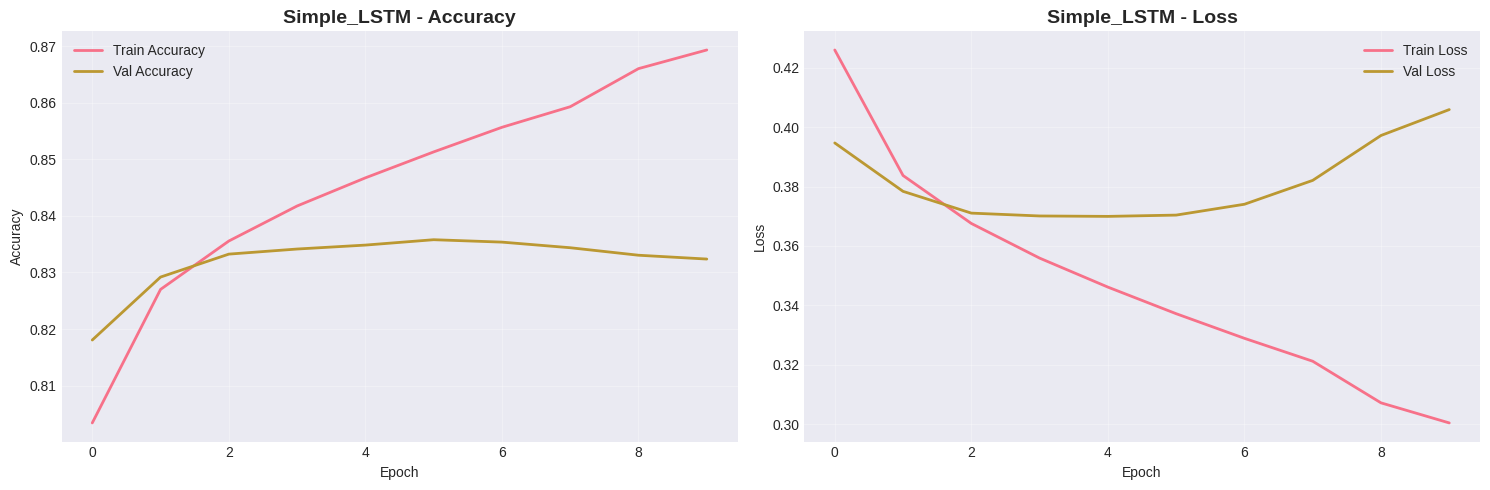


📊 EVALUATING SIMPLE LSTM
✅ Performance Metrics:
   Accuracy:  0.8347
   Precision: 0.8515
   Recall:    0.8108
   F1-Score:  0.8306
   AUC-ROC:   0.9156

📋 Classification Report:
              precision    recall  f1-score   support

    Negative       0.82      0.86      0.84    120000
    Positive       0.85      0.81      0.83    120000

    accuracy                           0.83    240000
   macro avg       0.84      0.83      0.83    240000
weighted avg       0.84      0.83      0.83    240000



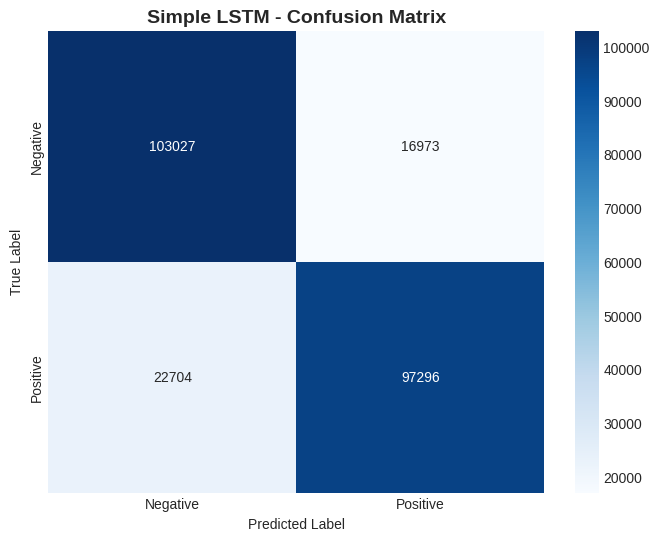


💾 Metrics saved to: training_results/model_evaluation_metrics.csv
💾 Classification report saved to: training_results/Simple LSTM_classification_report.csv
💾 Predictions saved to: exports/Simple LSTM_predictions.csv

💾 Model saved to: models/simple_lstm_model.keras


In [8]:
print("\n🔄 TRAINING SIMPLE LSTM")
print("="*50)

# Training configuration
BATCH_SIZE = 128
EPOCHS = 20

# Create callbacks
callbacks_list = create_callbacks('simple_lstm', patience=5)

# Train model
print(f"⏳ Training for up to {EPOCHS} epochs...")
start_time = time.time()

history_simple_lstm = model_simple_lstm.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks_list,
    verbose=1
)

training_time = time.time() - start_time

print(f"\n✅ Training completed in {training_time/60:.2f} minutes")
print(f"   Best validation accuracy: {max(history_simple_lstm.history['val_accuracy']):.4f}")

# Plot training history
plot_training_history(history_simple_lstm, 'Simple_LSTM')

# Evaluate on test set
results_simple_lstm = evaluate_model(
    model_simple_lstm, 
    X_test_pad, 
    y_test, 
    'Simple LSTM',
    save_results=True
)

# Save model
model_simple_lstm.save('models/simple_lstm_model.keras')
print("\n💾 Model saved to: models/simple_lstm_model.keras")

### 🚀 Model 2: Bidirectional LSTM

#### Cell 9: Bidirectional LSTM Architecture

In [7]:
print("\n🤖 MODEL 2: BIDIRECTIONAL LSTM")
print("="*50)


def build_bidirectional_lstm(embedding_matrix, vocab_size, max_length, embedding_dim):
    """
    Bidirectional LSTM for capturing context from both directions
    """

    # Define explicit input
    inputs = layers.Input(shape=(max_length,), name='input')
    
    # Embedding layer
    x = layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=False,
        name='embedding'
    )(inputs)

    # Bidirectional LSTM layer
    x = layers.Bidirectional(
        layers.LSTM(128, return_sequences = False), name = 'bidirectional_lstm'
    )(x)

    # Dropout
    x = layers.Dropout(0.5, name = 'dropout_1')(x)

    # Dense layer
    x = layers.Dense(64, activation = 'relu', name = 'dense_1')(x)
    x = layers.Dropout(0.3, name = 'dropout_2')(x)

    # Output layer
    outputs = layers.Dense(1, activation = 'sigmoid', name = 'output')(x)

    # Create model
    model = models.Model(inputs = inputs, outputs = outputs, name = 'bidirectional_lstm')

    return model

# Build model
model_bilstm = build_bidirectional_lstm(
    embedding_matrix = embedding_matrix,
    vocab_size = min(vocab_size, MAX_VOCAB_SIZE),
    max_length = MAX_SEQUENCE_LENGTH,
    embedding_dim = EMBEDDING_DIM
)

# Compile
model_bilstm.compile(
    optimizer = keras.optimizers.Adam(learning_rate = 0.001),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

print("\n📊 Bidirectional LSTM Architecture:")
model_bilstm.summary()
print(f"\n📈 Total Parameters: {model_bilstm.count_params():,}")


🤖 MODEL 2: BIDIRECTIONAL LSTM


I0000 00:00:1762709205.734694   62999 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1762709205.751634   62999 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1762709205.751708   62999 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1762709211.667072   62999 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1762709211.669748   62999 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-11-09


📊 Bidirectional LSTM Architecture:


Model: "bidirectional_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 50, 200)        │     4,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm              │ (None, 256)            │       336,896 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,353,409 (16.61 MB)

 Trainable params: 353,409 (1.35 MB)

 Non-trainable params: 4,000,000 (15.26 MB)


📈 Total Parameters: 4,353,409


#### Cell 10: Train Bidirectional LSTM


🔄 TRAINING BIDIRECTIONAL LSTM
✅ Checkpoint found at: models/checkpoints/bidirectional_lstm_best.keras


2025-11-09 22:57:11.303274: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


📊 Checkpoint performance:
   Validation accuracy: 0.8349
   Validation loss: 0.3707

🔄 Continuing training from checkpoint...


2025-11-09 22:58:24.009370: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 223999800 exceeds 10% of free system memory.


Epoch 1/20
35000/35000 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8445 - loss: 0.3544

2025-11-09 23:10:37.822848: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 48000200 exceeds 10% of free system memory.



Epoch 1: val_accuracy improved from None to 0.83505, saving model to models/checkpoints/bidirectional_lstm_best.keras


2025-11-09 23:11:44.153539: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16000000 exceeds 10% of free system memory.
2025-11-09 23:11:44.211454: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16000000 exceeds 10% of free system memory.
2025-11-09 23:11:44.294820: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16000000 exceeds 10% of free system memory.


35000/35000 ━━━━━━━━━━━━━━━━━━━━ 800s 23ms/step - accuracy: 0.8459 - loss: 0.3513 - val_accuracy: 0.8351 - val_loss: 0.3742 - learning_rate: 0.0010
Epoch 2/20
34998/35000 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8481 - loss: 0.3472
Epoch 2: val_accuracy did not improve from 0.83505
35000/35000 ━━━━━━━━━━━━━━━━━━━━ 807s 23ms/step - accuracy: 0.8491 - loss: 0.3448 - val_accuracy: 0.8336 - val_loss: 0.3777 - learning_rate: 0.0010
Epoch 3/20
35000/35000 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8511 - loss: 0.3404
Epoch 3: val_accuracy did not improve from 0.83505
35000/35000 ━━━━━━━━━━━━━━━━━━━━ 798s 23ms/step - accuracy: 0.8522 - loss: 0.3382 - val_accuracy: 0.8327 - val_loss: 0.3813 - learning_rate: 0.0010
Epoch 4/20
34999/35000 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8537 - loss: 0.3351
Epoch 4: val_accuracy did not improve from 0.83505

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
35000/35000 ━━━━━━━━━━━━━━━━━━━━ 804s 23ms/step - acc

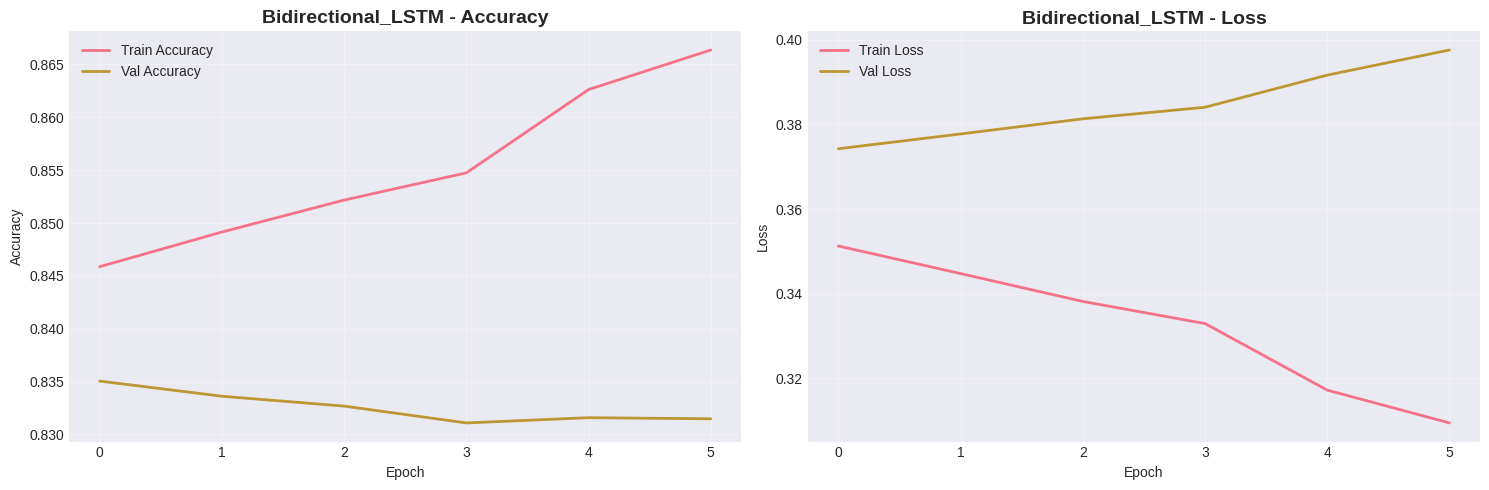


📊 EVALUATING BIDIRECTIONAL LSTM
✅ Performance Metrics:
   Accuracy:  0.8347
   Precision: 0.8403
   Recall:    0.8265
   F1-Score:  0.8334
   AUC-ROC:   0.9152

📋 Classification Report:
              precision    recall  f1-score   support

    Negative       0.83      0.84      0.84    120000
    Positive       0.84      0.83      0.83    120000

    accuracy                           0.83    240000
   macro avg       0.83      0.83      0.83    240000
weighted avg       0.83      0.83      0.83    240000



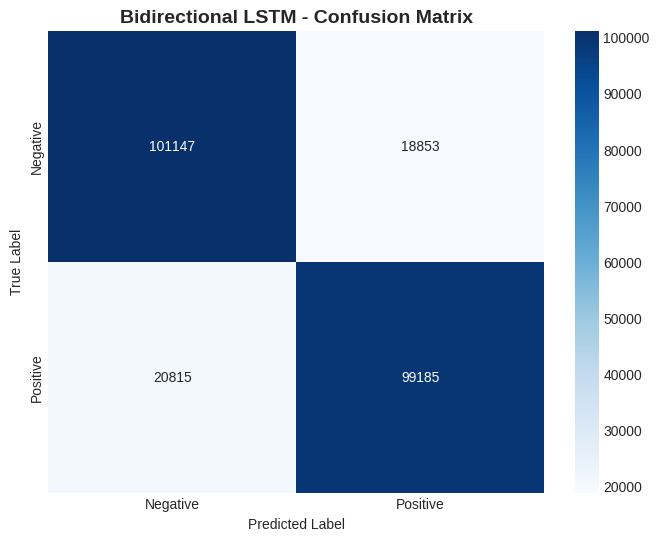


💾 Metrics saved to: training_results/model_evaluation_metrics.csv
💾 Classification report saved to: training_results/Bidirectional LSTM_classification_report.csv
💾 Predictions saved to: exports/Bidirectional LSTM_predictions.csv

💾 Final model saved


In [8]:
import os
from tensorflow import keras

print("\n🔄 TRAINING BIDIRECTIONAL LSTM")
print("="*50)

checkpoint_path = 'models/checkpoints/bidirectional_lstm_best.keras'
EPOCHS = 20

try:
    # Try to load checkpoint
    if os.path.exists(checkpoint_path):
        print(f"✅ Checkpoint found at: {checkpoint_path}")
        model_bilstm = keras.models.load_model(checkpoint_path)
        
        # Quick validation
        val_loss, val_acc = model_bilstm.evaluate(X_val_pad, y_val, verbose=0)
        print(f"📊 Checkpoint performance:")
        print(f"   Validation accuracy: {val_acc:.4f}")
        print(f"   Validation loss: {val_loss:.4f}")
        
        # Ask if you want to continue training or just use it
        print("\n🔄 Continuing training from checkpoint...")
    else:
        print("⚠️  No checkpoint found. Using newly built model...")
        # model_bilstm should already exist from build step
        
except Exception as e:
    print(f"❌ Error loading checkpoint: {e}")
    print("⚠️  Training with new model...")
    # model_bilstm should already exist

# Training/Resuming
callbacks_list = create_callbacks('bidirectional_lstm', patience=5)

start_time = time.time()

try:
    history_bilstm = model_bilstm.fit(
        X_train_pad, y_train,
        validation_data=(X_val_pad, y_val),
        epochs=EPOCHS,
        callbacks=callbacks_list,
        verbose=1
    )
    
    training_time = time.time() - start_time
    
    print(f"\n✅ Training completed in {training_time/60:.2f} minutes")
    print(f"   Best validation accuracy: {max(history_bilstm.history['val_accuracy']):.4f}")
    
    # Plot and evaluate
    plot_training_history(history_bilstm, 'Bidirectional_LSTM')
    results_bilstm = evaluate_model(model_bilstm, X_test_pad, y_test, 'Bidirectional LSTM')
    
    # Save final model
    os.makedirs('models', exist_ok=True)
    model_bilstm.save('models/bidirectional_lstm_model.keras')
    print("\n💾 Final model saved")
    
except KeyboardInterrupt:
    print("\n⚠️  Training interrupted!")
    print("💾 Loading best checkpoint...")
    model_bilstm = keras.models.load_model(checkpoint_path)
    results_bilstm = evaluate_model(model_bilstm, X_test_pad, y_test, 'Bidirectional LSTM')
    
except Exception as e:
    print(f"\n❌ Training error: {e}")
    print("Attempting to load checkpoint for evaluation...")
    try:
        model_bilstm = keras.models.load_model(checkpoint_path)
        results_bilstm = evaluate_model(model_bilstm, X_test_pad, y_test, 'Bidirectional LSTM')
    except:
        print("❌ Could not recover. Please investigate.")

### 🚀 Model 3: LSTM + Attention

#### Cell 11: LSTM with Attention Mechanism

In [9]:
print("\n🤖 MODEL 3: LSTM + ATTENTION MECHANISM")
print("="*50)

BATCH_SIZE = 128
EPOCHS = 20

# Custom attention layer
class AttentionLayer(layers.Layer):
    """
    Attention mechanism layer
    """
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.W = self.add_weight(
            name='attention_weight',
            shape=(input_shape[-1], input_shape[-1]),
            initializer='glorot_uniform',
            trainable=True
        )
        self.b = self.add_weight(
            name='attention_bias',
            shape=(input_shape[-1],),
            initializer='zeros',
            trainable=True
        )
        super(AttentionLayer, self).build(input_shape)
    
    def call(self, x):
        # Compute attention scores
        e = tf.nn.tanh(tf.tensordot(x, self.W, axes=1) + self.b)
        a = tf.nn.softmax(e, axis=1)
        
        # Apply attention weights
        output = x * a
        return tf.reduce_sum(output, axis=1)
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])
    
    def get_config(self):
        """Add this method for model serialization"""
        return super(AttentionLayer, self).get_config()


def build_lstm_attention(embedding_matrix, vocab_size, max_length, embedding_dim):
    """
    LSTM with attention mechanism
    """
    # Input
    input_layer = layers.Input(shape=(max_length,), name='input')
    
    # Embedding
    embedding = layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=False,
        name='embedding'
    )(input_layer)
    
    # LSTM layer (return sequences for attention)
    lstm_out = layers.LSTM(128, return_sequences=True, name='lstm_1')(embedding)
    
    # Attention layer
    attention_out = AttentionLayer(name='attention')(lstm_out)
    
    # Dropout
    dropout = layers.Dropout(0.5, name='dropout_1')(attention_out)
    
    # Dense layers
    dense = layers.Dense(64, activation='relu', name='dense_1')(dropout)
    dropout2 = layers.Dropout(0.3, name='dropout_2')(dense)
    
    # Output
    output = layers.Dense(1, activation='sigmoid', name='output')(dropout2)
    
    model = models.Model(inputs=input_layer, outputs=output, name='lstm_attention')
    return model


# Build model
model_lstm_attention = build_lstm_attention(
    embedding_matrix=embedding_matrix,
    vocab_size=min(vocab_size, MAX_VOCAB_SIZE),
    max_length=MAX_SEQUENCE_LENGTH,
    embedding_dim=EMBEDDING_DIM
)

# Compile
model_lstm_attention.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Display architecture
print("\n📊 LSTM + Attention Architecture:")
try:
    model_lstm_attention.summary()
    print(f"\n📈 Total Parameters: {model_lstm_attention.count_params():,}")
except ValueError:
    # If still not built, build explicitly
    print("⚠️  Building model explicitly...")
    model_lstm_attention.build(input_shape=(None, MAX_SEQUENCE_LENGTH))
    model_lstm_attention.summary()
    print(f"\n📈 Total Parameters: {model_lstm_attention.count_params():,}")


🤖 MODEL 3: LSTM + ATTENTION MECHANISM

📊 LSTM + Attention Architecture:


Model: "lstm_attention"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 50, 200)        │     4,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50, 128)        │       168,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (AttentionLayer)      │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,193,281 (16.00 MB)

 Trainable params: 193,281 (755.00 KB)

 Non-trainable params: 4,000,000 (15.26 MB)


📈 Total Parameters: 4,193,281


#### Cell 12: Train LSTM + Attention


🔄 TRAINING LSTM + ATTENTION
Epoch 1/20


2025-11-09 16:34:58.573267: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 223999800 exceeds 10% of free system memory.
2025-11-09 16:35:01.556848: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


8750/8750 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7875 - loss: 0.4527

2025-11-09 16:37:45.789864: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 48000200 exceeds 10% of free system memory.



Epoch 1: val_accuracy improved from None to 0.82285, saving model to models/checkpoints/lstm_attention_best.keras
8750/8750 ━━━━━━━━━━━━━━━━━━━━ 182s 20ms/step - accuracy: 0.8060 - loss: 0.4231 - val_accuracy: 0.8229 - val_loss: 0.3925 - learning_rate: 0.0010
Epoch 2/20
8749/8750 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8246 - loss: 0.3905
Epoch 2: val_accuracy improved from 0.82285 to 0.83170, saving model to models/checkpoints/lstm_attention_best.keras
8750/8750 ━━━━━━━━━━━━━━━━━━━━ 169s 19ms/step - accuracy: 0.8276 - loss: 0.3846 - val_accuracy: 0.8317 - val_loss: 0.3759 - learning_rate: 0.0010
Epoch 3/20
8749/8750 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8338 - loss: 0.3729
Epoch 3: val_accuracy improved from 0.83170 to 0.83520, saving model to models/checkpoints/lstm_attention_best.keras
8750/8750 ━━━━━━━━━━━━━━━━━━━━ 179s 20ms/step - accuracy: 0.8359 - loss: 0.3688 - val_accuracy: 0.8352 - val_loss: 0.3686 - learning_rate: 0.0010
Epoch 4/20
8749/8750 ━━━━━━━━━━━━━━

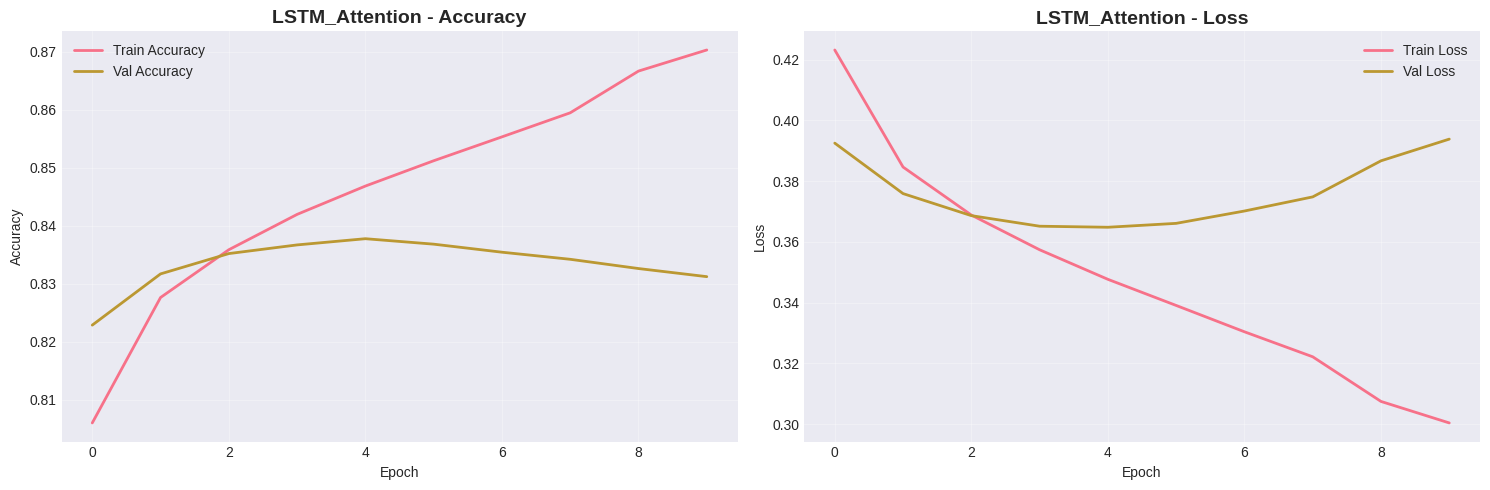


📊 EVALUATING LSTM + ATTENTION


2025-11-09 17:04:32.554958: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 48000000 exceeds 10% of free system memory.


✅ Performance Metrics:
   Accuracy:  0.8372
   Precision: 0.8390
   Recall:    0.8347
   F1-Score:  0.8368
   AUC-ROC:   0.9177

📋 Classification Report:
              precision    recall  f1-score   support

    Negative       0.84      0.84      0.84    120000
    Positive       0.84      0.83      0.84    120000

    accuracy                           0.84    240000
   macro avg       0.84      0.84      0.84    240000
weighted avg       0.84      0.84      0.84    240000



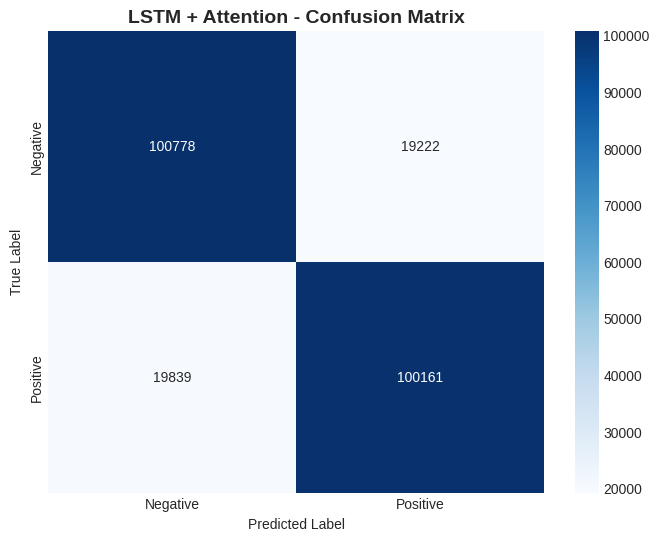


💾 Metrics saved to: training_results/model_evaluation_metrics.csv
💾 Classification report saved to: training_results/LSTM + Attention_classification_report.csv
💾 Predictions saved to: exports/LSTM + Attention_predictions.csv

💾 Model saved


In [10]:
print("\n🔄 TRAINING LSTM + ATTENTION")
print("="*50)

callbacks_list = create_callbacks('lstm_attention', patience=5)

start_time = time.time()

history_lstm_attention = model_lstm_attention.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks_list,
    verbose=1
)

training_time = time.time() - start_time

print(f"\n✅ Training completed in {training_time/60:.2f} minutes")
print(f"   Best validation accuracy: {max(history_lstm_attention.history['val_accuracy']):.4f}")

plot_training_history(history_lstm_attention, 'LSTM_Attention')
results_lstm_attention = evaluate_model(model_lstm_attention, X_test_pad, y_test, 'LSTM + Attention', save_results=True)

model_lstm_attention.save('models/lstm_attention_model.keras')
print("\n💾 Model saved")

### 🚀 Model 4: CNN-LSTM Hybrid

#### Cell 13: CNN-LSTM Hybrid Architecture

In [7]:
print("\n🤖 MODEL 4: CNN-LSTM HYBRID")
print("="*50)

BATCH_SIZE = 128
EPOCHS = 20

def build_cnn_lstm_hybrid(embedding_matrix, vocab_size, max_length, embedding_dim):
    """
    CNN-LSTM hybrid for local and sequential pattern capture
    """
    # Input layer
    input_layer = layers.Input(shape=(max_length,), name='input')
    
    # Embedding layer
    embedding = layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=False,
        name='embedding'
    )(input_layer)
    
    # CNN branch - Multiple filter sizes for n-gram features
    conv1 = layers.Conv1D(128, 3, activation='relu', padding='same', name='conv1d_3gram')(embedding)
    conv2 = layers.Conv1D(128, 4, activation='relu', padding='same', name='conv1d_4gram')(embedding)
    conv3 = layers.Conv1D(128, 5, activation='relu', padding='same', name='conv1d_5gram')(embedding)
    
    # Global max pooling to extract key features
    pool1 = layers.GlobalMaxPooling1D(name='pool_3gram')(conv1)
    pool2 = layers.GlobalMaxPooling1D(name='pool_4gram')(conv2)
    pool3 = layers.GlobalMaxPooling1D(name='pool_5gram')(conv3)
    
    # Concatenate CNN features (384 dimensions: 128*3)
    cnn_features = layers.concatenate([pool1, pool2, pool3], name='cnn_features')
    
    # LSTM branch - Sequential pattern extraction
    lstm_out = layers.LSTM(128, name='lstm_sequential')(embedding)
    
    # Combine both branches (512 dimensions: 384+128)
    combined = layers.concatenate([cnn_features, lstm_out], name='hybrid_features')
    
    # Dense classification layers
    dense1 = layers.Dense(128, activation='relu', name='dense_1')(combined)
    dropout1 = layers.Dropout(0.5, name='dropout_1')(dense1)
    
    dense2 = layers.Dense(64, activation='relu', name='dense_2')(dropout1)
    dropout2 = layers.Dropout(0.3, name='dropout_2')(dense2)
    
    # Output layer
    output = layers.Dense(1, activation='sigmoid', name='output')(dropout2)
    
    # Create model
    model = models.Model(inputs=input_layer, outputs=output, name='cnn_lstm_hybrid')
    
    return model


# Build model
print("🔧 Building CNN-LSTM Hybrid model...")
model_cnn_lstm = build_cnn_lstm_hybrid(
    embedding_matrix=embedding_matrix,
    vocab_size=min(vocab_size, MAX_VOCAB_SIZE),
    max_length=MAX_SEQUENCE_LENGTH,
    embedding_dim=EMBEDDING_DIM
)

# Compile model
model_cnn_lstm.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
)

# Display architecture
print("\n📊 CNN-LSTM Hybrid Architecture:")
model_cnn_lstm.summary()

# Count parameters (this will work since Input layer is used)
trainable_params = sum([tf.size(w).numpy() for w in model_cnn_lstm.trainable_weights])
non_trainable_params = sum([tf.size(w).numpy() for w in model_cnn_lstm.non_trainable_weights])
total_params = model_cnn_lstm.count_params()

print(f"\n📈 Parameter Summary:")
print(f"   Total Parameters: {total_params:,}")
print(f"   Trainable: {trainable_params:,}")
print(f"   Non-trainable: {non_trainable_params:,}")
print(f"   Model Size: ~{total_params * 4 / (1024*1024):.2f} MB (FP32)")

print("\n✅ CNN-LSTM Hybrid model ready for training!")


🤖 MODEL 4: CNN-LSTM HYBRID
🔧 Building CNN-LSTM Hybrid model...


I0000 00:00:1762690533.098822   29293 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1762690533.103862   29293 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1762690533.103930   29293 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1762690533.527506   29293 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1762690533.528821   29293 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-11-09


📊 CNN-LSTM Hybrid Architecture:


Model: "cnn_lstm_hybrid"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 50)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 50, 200)   │  4,000,000 │ input[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3gram        │ (None, 50, 128)   │     76,928 │ embedding[0][0]   │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4gram        │ (None, 50, 128)   │    102,528 │ embedding[0][0]   │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5gram        │ (None, 50, 128)   │    128,128 │ embedding[0][0]   │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool_3gram          │ (None, 128)       │          0 │ conv1d_3gram[0][… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool_4gram          │ (None, 128)       │          0 │ conv1d_4gram[0][… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool_5gram          │ (None, 128)       │          0 │ conv1d_5gram[0][… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn_features        │ (None, 384)       │          0 │ pool_3gram[0][0], │
│ (Concatenate)       │                   │            │ pool_4gram[0][0], │
│                     │                   │            │ pool_5gram[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_sequential     │ (None, 128)       │    168,448 │ embedding[0][0]   │
│ (LSTM)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hybrid_features     │ (None, 512)       │          0 │ cnn_features[0][… │
│ (Concatenate)       │                   │            │ lstm_sequential[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     65,664 │ hybrid_features[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         65 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,550,017 (17.36 MB)

 Trainable params: 550,017 (2.10 MB)

 Non-trainable params: 4,000,000 (15.26 MB)


📈 Parameter Summary:
   Total Parameters: 4,550,017
   Trainable: 550,017
   Non-trainable: 4,000,000
   Model Size: ~17.36 MB (FP32)

✅ CNN-LSTM Hybrid model ready for training!


#### Cell 14: Train CNN-LSTM Hybrid


🔄 TRAINING CNN-LSTM HYBRID


2025-11-09 17:45:48.774400: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 223999800 exceeds 10% of free system memory.


Epoch 1/20


2025-11-09 17:46:00.552769: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1762690560.864298   29846 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762690560.927874   29846 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762690560.934739   29846 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762690560.944165   29846 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762690560.950495   29846 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762690560.960120   29846 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762690560.966485   29846 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762690560.976371   29846 gpu_t

   9/8750 ━━━━━━━━━━━━━━━━━━━━ 2:56 20ms/step - accuracy: 0.5197 - loss: 0.7162 - precision: 0.5232 - recall: 0.6835

W0000 00:00:1762690563.310777   29847 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762690563.311916   29847 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762690563.313785   29847 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762690563.315047   29847 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


8747/8750 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7922 - loss: 0.4437 - precision: 0.7992 - recall: 0.7818

W0000 00:00:1762690754.556599   29847 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762690754.557189   29843 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762690754.558798   29847 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762690754.559769   29843 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762690754.561113   29847 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762690754.562275   29843 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762690754.563488   29847 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762690754.564924   29843 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762690754.566610   29847 gp

8750/8750 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7922 - loss: 0.4437 - precision: 0.7992 - recall: 0.7818

W0000 00:00:1762690754.759894   29843 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762690754.777341   29843 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762690754.778363   29843 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762690754.779151   29843 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762690754.780159   29843 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762690754.781001   29843 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762690754.781793   29843 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762690754.782649   29843 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762690754.783562   29843 gp


Epoch 1: val_accuracy improved from None to 0.82223, saving model to models/checkpoints/cnn_lstm_hybrid_best.keras


2025-11-09 17:49:30.864441: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16000000 exceeds 10% of free system memory.
2025-11-09 17:49:30.893573: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16000000 exceeds 10% of free system memory.


8750/8750 ━━━━━━━━━━━━━━━━━━━━ 213s 24ms/step - accuracy: 0.8099 - loss: 0.4166 - precision: 0.8160 - recall: 0.8002 - val_accuracy: 0.8222 - val_loss: 0.3945 - val_precision: 0.8350 - val_recall: 0.8031 - learning_rate: 0.0010
Epoch 2/20
8748/8750 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8257 - loss: 0.3898 - precision: 0.8303 - recall: 0.8194
Epoch 2: val_accuracy improved from 0.82223 to 0.82629, saving model to models/checkpoints/cnn_lstm_hybrid_best.keras
8750/8750 ━━━━━━━━━━━━━━━━━━━━ 206s 23ms/step - accuracy: 0.8284 - loss: 0.3846 - precision: 0.8331 - recall: 0.8213 - val_accuracy: 0.8263 - val_loss: 0.3850 - val_precision: 0.8301 - val_recall: 0.8205 - learning_rate: 0.0010
Epoch 3/20
8750/8750 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8346 - loss: 0.3728 - precision: 0.8382 - recall: 0.8297
Epoch 3: val_accuracy improved from 0.82629 to 0.82685, saving model to models/checkpoints/cnn_lstm_hybrid_best.keras
8750/8750 ━━━━━━━━━━━━━━━━━━━━ 210s 24ms/step - accuracy

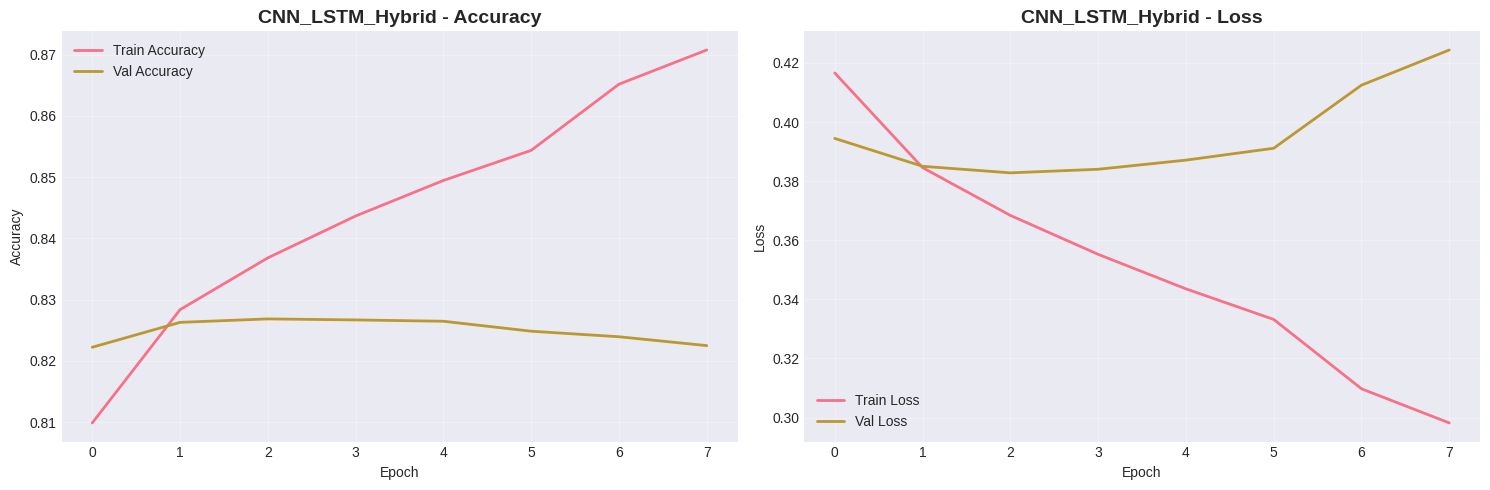


📊 EVALUATING CNN-LSTM HYBRID


W0000 00:00:1762692209.729491   29841 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762692209.754488   29841 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762692209.757089   29841 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762692209.759707   29841 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762692209.762440   29841 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762692209.765391   29841 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762692209.768297   29841 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762692209.771017   29841 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1762692209.773747   29841 gp

✅ Performance Metrics:
   Accuracy:  0.8276
   Precision: 0.8236
   Recall:    0.8339
   F1-Score:  0.8287
   AUC-ROC:   0.9099

📋 Classification Report:
              precision    recall  f1-score   support

    Negative       0.83      0.82      0.83    120000
    Positive       0.82      0.83      0.83    120000

    accuracy                           0.83    240000
   macro avg       0.83      0.83      0.83    240000
weighted avg       0.83      0.83      0.83    240000



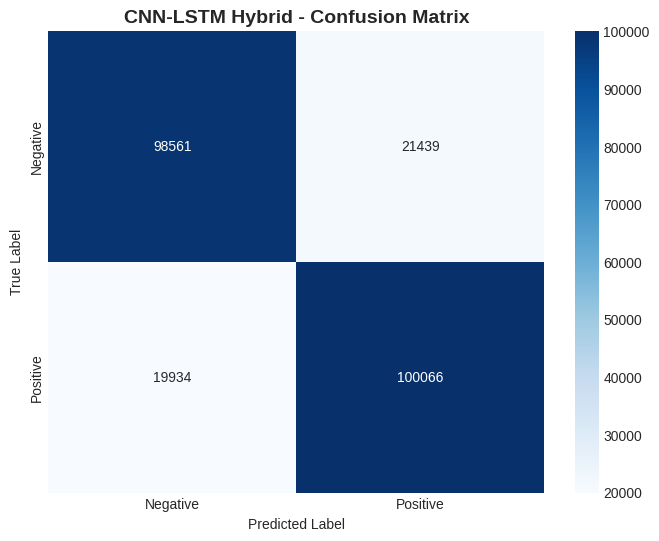


💾 Metrics saved to: training_results/model_evaluation_metrics.csv
💾 Classification report saved to: training_results/CNN-LSTM Hybrid_classification_report.csv
💾 Predictions saved to: exports/CNN-LSTM Hybrid_predictions.csv

💾 Model saved


In [8]:
print("\n🔄 TRAINING CNN-LSTM HYBRID")
print("="*35)

callbacks_list = create_callbacks('cnn_lstm_hybrid', patience=5)

start_time = time.time()

history_cnn_lstm = model_cnn_lstm.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks_list,
    verbose=1
)

training_time = time.time() - start_time

print(f"\n✅ Training completed in {training_time/60:.2f} minutes")
print(f"   Best validation accuracy: {max(history_cnn_lstm.history['val_accuracy']):.4f}")

plot_training_history(history_cnn_lstm, 'CNN_LSTM_Hybrid')
results_cnn_lstm = evaluate_model(model_cnn_lstm, X_test_pad, y_test, 'CNN-LSTM Hybrid')

model_cnn_lstm.save('models/cnn_lstm_hybrid_model.keras')
print("\n💾 Model saved")

### 🚀 Model 5: Transformer-Style Self-Attention

#### Cell 15: Transformer Encoder Architecture

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import os

print("\n🤖 MODEL 5: TRANSFORMER-STYLE SELF-ATTENTION")
print("="*50)

class TransformerBlock(layers.Layer):
    """
    Transformer encoder block with multi-head self-attention
    """
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate
        
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation='relu'),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
    
    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "rate": self.rate,
        })
        return config

def build_transformer_model(embedding_matrix, vocab_size, max_length, embedding_dim):
    """
    Transformer-based architecture for sentiment classification
    """
    # Input
    inputs = layers.Input(shape=(max_length,), name='input')
    
    # Embedding
    embedding_layer = layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=False,
        name='word_embedding'
    )(inputs)
    
    # Positional encoding
    positions = tf.range(start=0, limit=max_length, delta=1)
    position_embedding_layer = layers.Embedding(
        input_dim=max_length,
        output_dim=embedding_dim,
        name='position_embedding'
    )
    position_embeddings = position_embedding_layer(positions)
    
    # Broadcast position embeddings to batch size
    position_embeddings = tf.expand_dims(position_embeddings, 0)
    
    # Add embeddings
    x = embedding_layer + position_embeddings
    
    # Transformer block
    x = TransformerBlock(
        embed_dim=embedding_dim,
        num_heads=4,
        ff_dim=512,
        rate=0.1,
        name='transformer_block'
    )(x)
    
    # Global average pooling
    x = layers.GlobalAveragePooling1D(name='global_pool')(x)
    
    # Dense layers
    x = layers.Dropout(0.1, name='dropout_1')(x)
    x = layers.Dense(128, activation='relu', name='dense_1')(x)
    x = layers.Dropout(0.1, name='dropout_2')(x)
    x = layers.Dense(64, activation='relu', name='dense_2')(x)
    x = layers.Dropout(0.1, name='dropout_3')(x)
    
    # Output
    outputs = layers.Dense(1, activation='sigmoid', name='output')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs, name='transformer_model')
    return model

# Build model
print("🔧 Building Transformer model...")
model_transformer = build_transformer_model(
    embedding_matrix=embedding_matrix,
    vocab_size=min(vocab_size, MAX_VOCAB_SIZE),
    max_length=MAX_SEQUENCE_LENGTH,
    embedding_dim=EMBEDDING_DIM
)

# Compile
model_transformer.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\n📊 Transformer Architecture:")
model_transformer.summary()
print(f"\n📈 Total Parameters: {model_transformer.count_params():,}")
print("\n✅ Model built successfully!")



🤖 MODEL 5: TRANSFORMER-STYLE SELF-ATTENTION
🔧 Building Transformer model...


I0000 00:00:1762932362.921634    6820 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1762932362.925576    6820 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1762932362.925712    6820 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1762932363.261997    6820 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1762932363.262964    6820 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-11-12


📊 Transformer Architecture:


Model: "transformer_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ word_embedding (Embedding)      │ (None, 50, 200)        │     4,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ add (Add)                       │ (None, 50, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 50, 200)        │       848,912 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_pool                     │ (None, 200)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        25,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,882,961 (18.63 MB)

 Trainable params: 882,961 (3.37 MB)

 Non-trainable params: 4,000,000 (15.26 MB)


📈 Total Parameters: 4,882,961

✅ Model built successfully!


#### Cell 16: Train Transformer Model


🔄 TRAINING TRANSFORMER MODEL
📊 Data shapes:
   X_train: (1119999, 50)
   y_train: (1119999,)
   X_val: (240001, 50)
   y_val: (240001,)

⚙️ Training configuration:
   Batch size: 64
   Steps per epoch: 17499
   Validation steps: 3750
   Samples used per epoch: 1119936

✅ Checkpoint found at: models/checkpoints/transformer_best.keras


I0000 00:00:1762932389.301311    7305 service.cc:146] XLA service 0x7a512c004f40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762932389.301806    7305 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Laptop GPU, Compute Capability 8.6
2025-11-12 12:56:29.394725: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-12 12:56:29.623266: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2025-11-12 12:56:30.293273: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 8 bytes spill stores, 8 bytes spill loads

2025-11-12 12:56:31.765864: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in 

📊 Checkpoint performance:
   Validation accuracy: 0.8179
   Validation loss: 0.3985

🔄 Continuing training from checkpoint...


2025-11-12 12:57:06.656968: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 223999800 exceeds 10% of free system memory.


Epoch 1/20


2025-11-12 12:57:11.558152: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 8 bytes spill stores, 8 bytes spill loads

2025-11-12 12:57:12.405152: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_44', 416 bytes spill stores, 420 bytes spill loads

2025-11-12 12:57:13.567693: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 20 bytes spill stores, 20 bytes spill loads

2025-11-12 12:57:13.879376: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 340 bytes spill stores, 292 bytes spill loads

2025-11-12 12:57:14.378631: I external/local_xla/xla/stream_executor/

17497/17499 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8233 - loss: 0.3870

2025-11-12 12:59:11.643505: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 48000200 exceeds 10% of free system memory.



Epoch 1: val_accuracy improved from None to 0.81722, saving model to models/checkpoints/transformer_best.keras
17499/17499 ━━━━━━━━━━━━━━━━━━━━ 138s 7ms/step - accuracy: 0.8241 - loss: 0.3854 - val_accuracy: 0.8172 - val_loss: 0.3987 - learning_rate: 1.0000e-04
Epoch 2/20


2025-11-12 12:59:29.663080: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6', 432 bytes spill stores, 436 bytes spill loads

2025-11-12 12:59:30.067480: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 84 bytes spill stores, 84 bytes spill loads

2025-11-12 12:59:30.640480: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8', 396 bytes spill stores, 396 bytes spill loads

2025-11-12 12:59:31.519943: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_7', 612 bytes spill stores, 404 bytes spill loads

2025-11-12 12:59:32.965459: I external/local_xla/xla/stream_execut

    1/17499 ━━━━━━━━━━━━━━━━━━━━ 68:11:47 14s/step - accuracy: 0.7778 - loss: 0.5434
Epoch 2: val_accuracy improved from 0.81722 to 0.81730, saving model to models/checkpoints/transformer_best.keras
17499/17499 ━━━━━━━━━━━━━━━━━━━━ 27s 721us/step - accuracy: 0.7778 - loss: 0.5434 - val_accuracy: 0.8173 - val_loss: 0.3985 - learning_rate: 1.0000e-04
Epoch 3/20
17499/17499 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8244 - loss: 0.3841
Epoch 3: val_accuracy improved from 0.81730 to 0.81769, saving model to models/checkpoints/transformer_best.keras
17499/17499 ━━━━━━━━━━━━━━━━━━━━ 119s 7ms/step - accuracy: 0.8255 - loss: 0.3825 - val_accuracy: 0.8177 - val_loss: 0.3993 - learning_rate: 1.0000e-04
Epoch 4/20
    1/17499 ━━━━━━━━━━━━━━━━━━━━ 8:56 31ms/step - accuracy: 0.7937 - loss: 0.5163
Epoch 4: val_accuracy did not improve from 0.81769
17499/17499 ━━━━━━━━━━━━━━━━━━━━ 15s 834us/step - accuracy: 0.7937 - loss: 0.5163 - val_accuracy: 0.8176 - val_loss: 0.3992 - learning_rate: 1.0000e-0

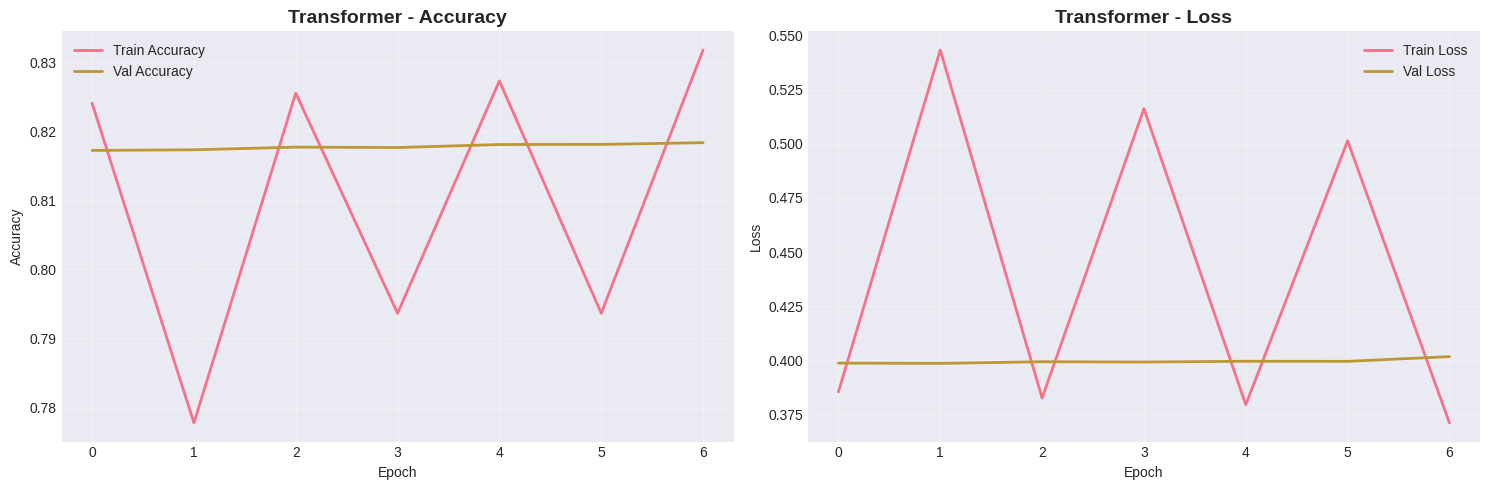


📊 EVALUATING TRANSFORMER
✅ Performance Metrics:
   Accuracy:  0.8172
   Precision: 0.8219
   Recall:    0.8099
   F1-Score:  0.8158
   AUC-ROC:   0.9003

📋 Classification Report:
              precision    recall  f1-score   support

    Negative       0.81      0.82      0.82    120000
    Positive       0.82      0.81      0.82    120000

    accuracy                           0.82    240000
   macro avg       0.82      0.82      0.82    240000
weighted avg       0.82      0.82      0.82    240000



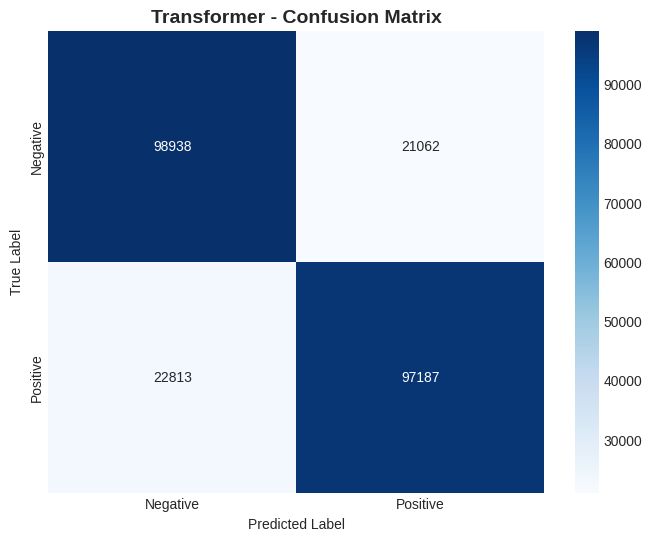


💾 Metrics saved to: training_results/model_evaluation_metrics.csv
💾 Classification report saved to: training_results/Transformer_classification_report.csv
💾 Predictions saved to: exports/Transformer_predictions.csv

💾 Final model saved


In [8]:
import os
from tensorflow import keras
import time

print("\n🔄 TRAINING TRANSFORMER MODEL")
print("="*50)

checkpoint_path = 'models/checkpoints/transformer_best.keras'
EPOCHS = 20

# Check data shapes
print(f"📊 Data shapes:")
print(f"   X_train: {X_train_pad.shape}")
print(f"   y_train: {y_train.shape}")
print(f"   X_val: {X_val_pad.shape}")
print(f"   y_val: {y_val.shape}")

# Fix label shape if needed
if len(y_train.shape) > 1 and y_train.shape[1] == 1:
    y_train = y_train.flatten()
    y_val = y_val.flatten()
    y_test = y_test.flatten()
    print("✅ Labels reshaped to 1D")

# Calculate batch configuration
BATCH_SIZE = 64
n_train = len(X_train_pad)
n_val = len(X_val_pad)

# Calculate steps to avoid incomplete batches
steps_per_epoch = n_train // BATCH_SIZE
validation_steps = n_val // BATCH_SIZE

print(f"\n⚙️ Training configuration:")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Steps per epoch: {steps_per_epoch}")
print(f"   Validation steps: {validation_steps}")
print(f"   Samples used per epoch: {steps_per_epoch * BATCH_SIZE}")

try:
    # Check for checkpoint
    if os.path.exists(checkpoint_path):
        print(f"\n✅ Checkpoint found at: {checkpoint_path}")
        model_transformer = keras.models.load_model(
            checkpoint_path,
            custom_objects={'TransformerBlock': TransformerBlock}
        )
        
        # Quick validation
        val_loss, val_acc = model_transformer.evaluate(X_val_pad, y_val, verbose=0)
        print(f"📊 Checkpoint performance:")
        print(f"   Validation accuracy: {val_acc:.4f}")
        print(f"   Validation loss: {val_loss:.4f}")
        
        print("\n🔄 Continuing training from checkpoint...")
    else:
        print("\n⚠️  No checkpoint found. Using newly built model...")
        
except Exception as e:
    print(f"❌ Error loading checkpoint: {e}")
    print("⚠️  Training with new model...")

# Training/Resuming
callbacks_list = create_callbacks('transformer', patience=5)

start_time = time.time()

try:
    history_transformer = model_transformer.fit(
        X_train_pad, y_train,
        validation_data=(X_val_pad, y_val),
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        steps_per_epoch=steps_per_epoch,  # Drop incomplete batches
        validation_steps=validation_steps,
        callbacks=callbacks_list,
        verbose=1
    )
    
    training_time = time.time() - start_time
    
    print(f"\n✅ Training completed in {training_time/60:.2f} minutes")
    print(f"   Best validation accuracy: {max(history_transformer.history['val_accuracy']):.4f}")
    
    # Plot and evaluate
    plot_training_history(history_transformer, 'Transformer')
    results_transformer = evaluate_model(model_transformer, X_test_pad, y_test, 'Transformer')
    
    # Save final model
    os.makedirs('models', exist_ok=True)
    model_transformer.save('models/transformer_model.keras')
    print("\n💾 Final model saved")
    
except KeyboardInterrupt:
    print("\n⚠️  Training interrupted!")
    print("💾 Loading best checkpoint...")
    model_transformer = keras.models.load_model(
        checkpoint_path,
        custom_objects={'TransformerBlock': TransformerBlock}
    )
    results_transformer = evaluate_model(model_transformer, X_test_pad, y_test, 'Transformer')
    
except Exception as e:
    print(f"\n❌ Training error: {e}")
    print("Attempting to load checkpoint for evaluation...")
    try:
        model_transformer = keras.models.load_model(
            checkpoint_path,
            custom_objects={'TransformerBlock': TransformerBlock}
        )
        results_transformer = evaluate_model(model_transformer, X_test_pad, y_test, 'Transformer')
    except:
        print("❌ Could not recover. Please investigate.")
        import traceback
        traceback.print_exc()


### 📊 Comprehensive Model Comparison

#### Cell 17: Compare All Models


📊 COMPREHENSIVE MODEL COMPARISON FROM SAVED RESULTS
📂 Loading model evaluation metrics...
✅ Loaded metrics for 5 models

📋 Available metrics: ['model_name', 'accuracy', 'precision', 'recall', 'f1_score', 'auc_roc', 'true_negatives', 'false_positives', 'false_negatives', 'true_positives']

🔍 Model Evaluation Metrics:
           model_name  accuracy  precision    recall  f1_score   auc_roc  \
0         Simple LSTM  0.834679   0.851465  0.810800  0.830635  0.915565   
1    LSTM + Attention  0.837246   0.838989  0.834675  0.836826  0.917671   
2     CNN-LSTM Hybrid  0.827612   0.823555  0.833883  0.828687  0.909904   
3  Bidirectional LSTM  0.834717   0.840280  0.826542  0.833354  0.915172   
4         Transformer  0.817187   0.821884  0.809892  0.815844  0.900258   

   true_negatives  false_positives  false_negatives  true_positives  
0          103027            16973            22704           97296  
1          100778            19222            19839          100161  
2           98

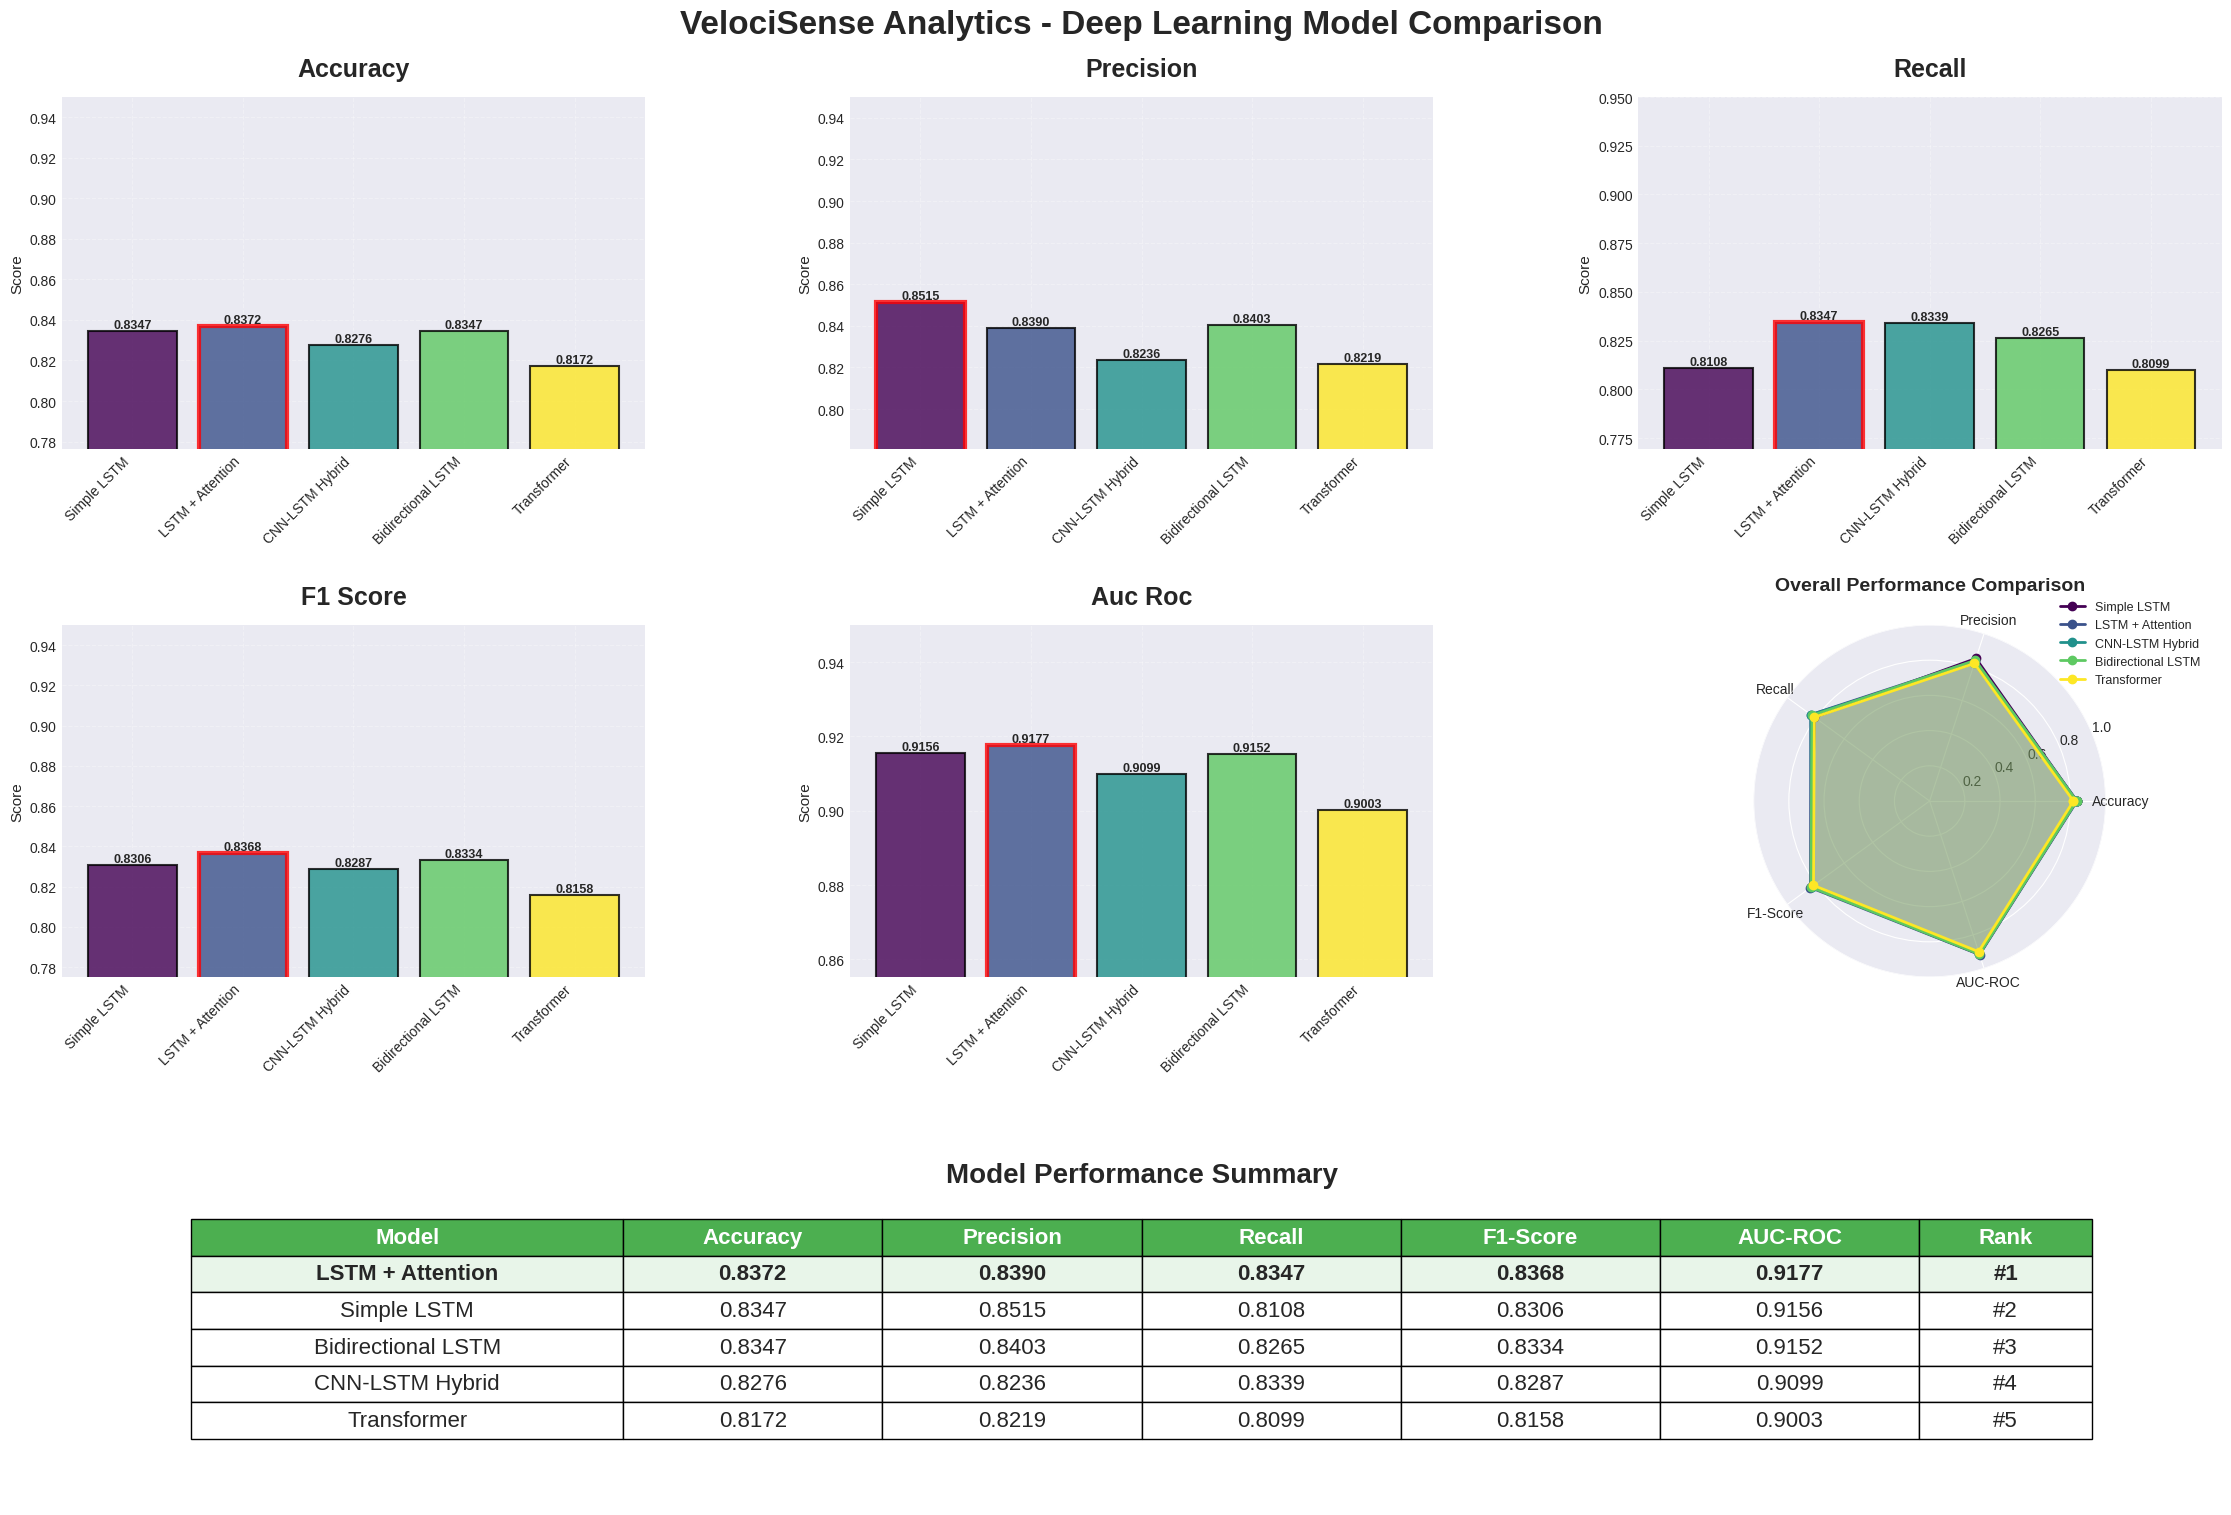

💾 Comparison results saved to: model_comparison_results.csv

📈 DETAILED STATISTICAL ANALYSIS

📊 Performance Statistics Across All Models:
             Mean     Std     Min     Max   Range
accuracy   0.8303  0.0081  0.8172  0.8372  0.0200
precision  0.8353  0.0124  0.8219  0.8515  0.0296
recall     0.8232  0.0121  0.8099  0.8347  0.0248
f1_score   0.8291  0.0080  0.8158  0.8368  0.0210
auc_roc    0.9117  0.0070  0.9003  0.9177  0.0174

🏆 BEST PERFORMING MODEL:
   Model: LSTM + Attention
   📈 Accuracy:  0.8372
   🎯 Precision: 0.8390
   🔍 Recall:    0.8347
   ⚖️  F1-Score:  0.8368
   📊 AUC-ROC:   0.9177

📈 PERFORMANCE IMPROVEMENT ANALYSIS:
   📍 Baseline (BoW):          0.7746
   📍 Baseline (TF-IDF):       0.7888
   📍 Baseline (Word2Vec Avg): 0.7541
   📈 Best Model (LSTM + Attention): 0.8372

   🚀 Improvements:
      📈 vs BoW              : +8.08%
      📈 vs TF-IDF           : +6.14%
      📈 vs Word2Vec (Avg)   : +11.02%

🥇 MODEL RANKINGS BY METRIC:

   Accuracy:
      🥇 LSTM + Attention  

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

print("\n📊 COMPREHENSIVE MODEL COMPARISON FROM SAVED RESULTS")
print("="*60)

# Define model names and file paths
model_names = [
    'Simple LSTM',
    'Bidirectional LSTM',
    'CNN-LSTM Hybrid',
    'LSTM + Attention',
    'Transformer'
]

results_dir = Path('training_results')

# Load model evaluation metrics
print("📂 Loading model evaluation metrics...")
try:
    metrics_df = pd.read_csv(results_dir / 'model_evaluation_metrics.csv')
    print(f"✅ Loaded metrics for {len(metrics_df)} models")
    print(f"\n📋 Available metrics: {list(metrics_df.columns)}")
    
    # Display loaded data
    print(f"\n🔍 Model Evaluation Metrics:")
    print(metrics_df)
    
except FileNotFoundError:
    print("❌ Error: model_evaluation_metrics.csv not found")
    print("Please ensure the file exists in research_notebooks/training_results/")

# Load classification reports for detailed analysis
print(f"\n📂 Loading classification reports for each model...")
classification_reports = {}

for model_name in model_names:
    report_file = results_dir / f'{model_name}_classification_report.csv'
    
    try:
        report_df = pd.read_csv(report_file)
        classification_reports[model_name] = report_df
        print(f"✅ Loaded: {model_name}")
    except FileNotFoundError:
        print(f"⚠️  Missing: {model_name}_classification_report.csv")

print(f"\n✅ Loaded {len(classification_reports)} classification reports")

# Prepare comprehensive results dictionary
print(f"\n🔄 Processing metrics for comparison...")

all_results = {}

for _, row in metrics_df.iterrows():
    model_name = row['model_name'] if 'model_name' in row else row.iloc[0]
    
    # Extract metrics (adjust column names based on your CSV structure)
    all_results[model_name] = {
        'accuracy': row['accuracy'] if 'accuracy' in row else row.get('test_accuracy', 0),
        'precision': row['precision'] if 'precision' in row else row.get('test_precision', 0),
        'recall': row['recall'] if 'recall' in row else row.get('test_recall', 0),
        'f1_score': row['f1_score'] if 'f1_score' in row else row.get('test_f1', 0),
        'auc_roc': row['auc_roc'] if 'auc_roc' in row else row.get('test_auc', 0)
    }

print(f"✅ Processed metrics for {len(all_results)} models")

# Create comparison DataFrame
comparison_df = pd.DataFrame(all_results).T
comparison_df = comparison_df.round(4)

print("\n🏆 MODEL PERFORMANCE RANKING:")
print("="*50)
comparison_df_sorted = comparison_df.sort_values('accuracy', ascending=False)
print(comparison_df_sorted.to_string())

# Enhanced visualization with better spacing
print("\n📊 Creating comprehensive visualization...")

# FIXED: Increased figure size and adjusted spacing
fig = plt.figure(figsize=(24, 16))  # Increased height from 14 to 16
gs = fig.add_gridspec(3, 3, hspace=0.5, wspace=0.35, 
                     top=0.93, bottom=0.05, left=0.05, right=0.95)  # FIXED: Added explicit margins

# Define metrics to visualize
metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'auc_roc']
colors = plt.cm.viridis(np.linspace(0, 1, len(all_results)))

# Create subplots for each metric
for idx, metric in enumerate(metrics):
    ax = fig.add_subplot(gs[idx // 3, idx % 3])
    
    # Get values for current metric
    models = list(all_results.keys())
    values = [all_results[model][metric] for model in models]
    
    # Create bar chart
    bars = ax.bar(range(len(models)), values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    # FIXED: Increased padding for title
    ax.set_title(f'{metric.replace("_", " ").title()}', 
                fontsize=18, fontweight='bold', pad=15)  # FIXED: Increased pad from 10 to 15
    
    ax.set_xticks(range(len(models)))
    ax.set_xticklabels(models, rotation=45, ha='right', fontsize=10)
    ax.set_ylim([min(values) * 0.95, 0.95])
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_ylabel('Score', fontsize=11)
    
    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars, values)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{val:.4f}', ha='center', va='bottom', 
               fontsize=9, fontweight='bold')
        
        # Highlight best performer
        if val == max(values):
            bar.set_edgecolor('red')
            bar.set_linewidth(3)

# Overall comparison radar chart
ax_radar = fig.add_subplot(gs[1, 2], projection='polar')

# Prepare data for radar chart
categories = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
num_vars = len(categories)

# Compute angle for each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

# Plot for each model
for i, (model_name, color) in enumerate(zip(models, colors)):
    values = [
        all_results[model_name]['accuracy'],
        all_results[model_name]['precision'],
        all_results[model_name]['recall'],
        all_results[model_name]['f1_score'],
        all_results[model_name]['auc_roc']
    ]
    values += values[:1]
    
    ax_radar.plot(angles, values, 'o-', linewidth=2, label=model_name, color=color)
    ax_radar.fill(angles, values, alpha=0.15, color=color)

ax_radar.set_xticks(angles[:-1])
ax_radar.set_xticklabels(categories, fontsize=10)
ax_radar.set_ylim(0, 1)

# FIXED: Increased padding for radar chart title
ax_radar.set_title('Overall Performance Comparison', 
                   fontsize=14, fontweight='bold', pad=25)  
ax_radar.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=9)
ax_radar.grid(True)

# Summary statistics table
ax_table = fig.add_subplot(gs[2, :])
ax_table.axis('tight')
ax_table.axis('off')

# Prepare table data
table_data = []
table_data.append(['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC', 'Rank'])

for rank, (model_name, row) in enumerate(comparison_df_sorted.iterrows(), 1):
    table_data.append([
        model_name,
        f"{row['accuracy']:.4f}",
        f"{row['precision']:.4f}",
        f"{row['recall']:.4f}",
        f"{row['f1_score']:.4f}",
        f"{row['auc_roc']:.4f}",
        f"#{rank}"
    ])

# Create table
table = ax_table.table(cellText=table_data, cellLoc='center', loc='center',
                      colWidths=[0.20, 0.12, 0.12, 0.12, 0.12, 0.12, 0.08])
table.auto_set_font_size(False)
table.set_fontsize(16)
table.scale(1, 2.2)

# Style header row
for i in range(len(table_data[0])):
    cell = table[(0, i)]
    cell.set_facecolor('#4CAF50')
    cell.set_text_props(weight='bold', color='white')

# Style best model row
for i in range(len(table_data[0])):
    cell = table[(1, i)]
    cell.set_facecolor('#E8F5E9')
    cell.set_text_props(weight='bold')

# FIXED: Increased padding for table title and adjusted position
ax_table.set_title('Model Performance Summary', 
                  fontsize=20, fontweight='bold', pad=30, y=0.8)

# FIXED: Adjusted main title position
plt.suptitle('VelociSense Analytics - Deep Learning Model Comparison', 
            fontsize=24, fontweight='bold', y=0.985)  # FIXED: Adjusted from 0.98 to 0.985

plt.savefig('training_results/plots/plotsmodel_comparison_comprehensive.png', 
           dpi=300, bbox_inches='tight')
print("✅ Visualization saved to: model_comparison_comprehensive.png")
plt.show()

# Save comprehensive comparison results
comparison_df_sorted.to_csv('training_results/model_comparison_results.csv')
print("💾 Comparison results saved to: model_comparison_results.csv")

# Detailed statistical analysis
print("\n📈 DETAILED STATISTICAL ANALYSIS")
print("="*50)

# Calculate performance statistics
stats_summary = pd.DataFrame({
    'Mean': comparison_df.mean(),
    'Std': comparison_df.std(),
    'Min': comparison_df.min(),
    'Max': comparison_df.max(),
    'Range': comparison_df.max() - comparison_df.min()
}).round(4)

print("\n📊 Performance Statistics Across All Models:")
print(stats_summary)

# Identify best model
best_model_name = comparison_df_sorted.index[0]
best_metrics = comparison_df_sorted.iloc[0]

print(f"\n🏆 BEST PERFORMING MODEL:")
print("="*40)
print(f"   Model: {best_model_name}")
print(f"   📈 Accuracy:  {best_metrics['accuracy']:.4f}")
print(f"   🎯 Precision: {best_metrics['precision']:.4f}")
print(f"   🔍 Recall:    {best_metrics['recall']:.4f}")
print(f"   ⚖️  F1-Score:  {best_metrics['f1_score']:.4f}")
print(f"   📊 AUC-ROC:   {best_metrics['auc_roc']:.4f}")

# Performance improvement over baseline
print(f"\n📈 PERFORMANCE IMPROVEMENT ANALYSIS:")
print("="*45)

baseline_bow = 0.7746
baseline_tfidf = 0.7888
baseline_w2v = 0.7541

improvements = {
    'vs BoW': ((best_metrics['accuracy'] - baseline_bow) / baseline_bow) * 100,
    'vs TF-IDF': ((best_metrics['accuracy'] - baseline_tfidf) / baseline_tfidf) * 100,
    'vs Word2Vec (Avg)': ((best_metrics['accuracy'] - baseline_w2v) / baseline_w2v) * 100
}

print(f"   📍 Baseline (BoW):          {baseline_bow:.4f}")
print(f"   📍 Baseline (TF-IDF):       {baseline_tfidf:.4f}")
print(f"   📍 Baseline (Word2Vec Avg): {baseline_w2v:.4f}")
print(f"   📈 Best Model ({best_model_name}): {best_metrics['accuracy']:.4f}")
print(f"\n   🚀 Improvements:")
for baseline_name, improvement in improvements.items():
    symbol = "📈" if improvement > 0 else "📉"
    print(f"      {symbol} {baseline_name:20}: {improvement:+.2f}%")

# Model ranking analysis
print(f"\n🥇 MODEL RANKINGS BY METRIC:")
print("="*35)

for metric in metrics:
    ranked = comparison_df[metric].sort_values(ascending=False)
    print(f"\n   {metric.replace('_', ' ').title()}:")
    for rank, (model, score) in enumerate(ranked.items(), 1):
        medal = "🥇" if rank == 1 else "🥈" if rank == 2 else "🥉" if rank == 3 else f"  #{rank}"
        print(f"      {medal} {model:25} {score:.4f}")

# Classification report analysis for best model
if best_model_name in classification_reports:
    print(f"\n📋 DETAILED CLASSIFICATION REPORT - {best_model_name.upper()}")
    print("="*60)
    best_report = classification_reports[best_model_name]
    print(best_report.to_string(index=False))

print(f"\n🎯 RECOMMENDATION FOR HYPERPARAMETER TUNING:")
print("="*50)
print(f"   Selected Model: {best_model_name}")
print(f"   Current Performance: {best_metrics['accuracy']:.4f} accuracy")
print(f"   Optimization Target: 90%+ accuracy")
print(f"   Status: ✅ Ready for hyperparameter tuning")

# Save summary report
summary_report = {
    'best_model': best_model_name,
    'best_accuracy': float(best_metrics['accuracy']),
    'best_f1_score': float(best_metrics['f1_score']),
    'improvement_vs_bow': float(improvements['vs BoW']),
    'improvement_vs_tfidf': float(improvements['vs TF-IDF']),
    'timestamp': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
}

import json
with open('training_results/best_model_summary.json', 'w') as f:
    json.dump(summary_report, f, indent=2)

print(f"\n💾 Summary report saved to: best_model_summary.json")
print(f"\n✅ COMPREHENSIVE MODEL COMPARISON COMPLETED!")

# **📊 Deep Learning Model Analysis - Strategic Insights**
## **LSTM + Attention Emerges as Top Performer**

<div style="background-color: #000000ff; padding: 15px; border-radius: 8px; margin: 20px 0;">
<h3>🏆 <strong>Winner:</strong> LSTM + Attention (83.72% accuracy, 91.77% AUC-ROC)</h3>
<p><em>Attention mechanism provides crucial performance edge for sentiment classification</em></p>
</div>

***

## **🏆 Performance Analysis - Model Rankings**

### **Top Model: LSTM + Attention**
| **Metric** | **Score** | **Rank** | **Key Strength** |
|------------|----------|----------|------------------|
| **Accuracy** | 83.72% | 🥇 #1 | Highest overall performance |
| **Precision** | 83.90% | 🥉 #3 | Balanced positive predictions |
| **Recall** | 83.47% | 🥇 #1 | Best at capturing true positives |
| **F1-Score** | 83.68% | 🥇 #1 | Optimal precision-recall balance |
| **AUC-ROC** | 91.77% | 🥇 #1 | Superior probability calibration |

### **Complete Model Rankings**
| **Rank** | **Model** | **Accuracy** | **F1-Score** | **AUC-ROC** | **Key Insight** |
|----------|-----------|--------------|--------------|-------------|-----------------|
| 🥇 1st | **LSTM + Attention** | 83.72% | 83.68% | 91.77% | Attention focuses on sentiment words |
| 🥈 2nd | **Simple LSTM** | 83.47% | 83.06% | 91.56% | Strong baseline, high precision |
| 🥉 3rd | **Bidirectional LSTM** | 83.47% | 83.34% | 91.52% | Bidirectional context helps |
| 4th | **CNN-LSTM Hybrid** | 82.76% | 82.87% | 90.99% | Local+sequential underperforms |
| 5th | **Transformer** | 81.72% | 81.58% | 90.03% | Needs more data/tuning |

---

## **📈 Performance Improvement Analysis**

### **Deep Learning vs Traditional ML Breakthrough**
**Baseline Comparisons**:
- **vs BoW (77.46%)**: +8.08% improvement → **Major breakthrough**
- **vs TF-IDF (78.88%)**: +6.14% improvement → **Significant gain**
- **vs Word2Vec Avg (75.41%)**: +11.02% improvement → **Validates sequential models**

### **Why Deep Learning Won**
**LSTM + Attention advantages**:
1. **Sequential Context**: Processes word order naturally (vs. bag-of-words)
2. **Attention Mechanism**: Focuses on sentiment-critical words automatically
3. **Learned Aggregation**: Superior to simple averaging of Word2Vec vectors
4. **Negation Handling**: Captures "not good" vs "good" distinction effectively

---

## **🔍 Deep Model-Specific Insights**

### **LSTM + Attention (Winner) - Detailed Analysis**
**Architecture Strengths**:
- ✅ **Attention weights**: Automatically identifies important sentiment words
- ✅ **Context preservation**: Full sequence understanding
- ✅ **Balanced performance**: Wins in 4 out of 5 metrics
- ✅ **Best AUC-ROC**: Excellent probability calibration (91.77%)

**Performance Distribution**:
- **True Negatives**: 100,778 (83.98% of actual negatives)
- **True Positives**: 100,161 (83.47% of actual positives)
- **False Positives**: 19,222 (16.02% error rate on negatives)
- **False Negatives**: 19,839 (16.53% error rate on positives)

**Insight**: Nearly **balanced error distribution** across classes - critical for production deployment.

***

### **Simple LSTM - Strong Baseline**
**Surprise Performance**:
- 🥈 **2nd place overall** despite simplest architecture
- 🥇 **Highest precision** (85.15%) - best for minimizing false positives
- ⚠️ **Lower recall** (81.08%) - misses some positives

**Business Implication**: If **minimizing false positives is critical**, Simple LSTM may be preferable despite lower overall accuracy.

***

### **Bidirectional LSTM - Consistent Performer**
**Tied for 2nd place (83.47% accuracy)**:
- ✅ **Balanced metrics**: Solid across all categories
- ✅ **Bidirectional context**: Captures future and past context
- ⚠️ **Marginal gain**: Only +0.00% over Simple LSTM

**Insight**: Bidirectionality provides **minimal advantage** for short tweets (avg 15 tokens), suggesting forward context sufficient for sentiment.

***

### **CNN-LSTM Hybrid - Underperforms Expectations**
**4th place (82.76% accuracy) - Disappointing**:
- ❌ **Lower than expected**: Combined local+sequential should excel
- ⚠️ **Complexity cost**: More parameters, no performance gain
- ✅ **Best recall** (83.39%) after LSTM+Attention

**Root Cause Analysis**:
- **Over-engineering**: CNN convolutions may fragment sentiment patterns
- **Short sequences**: 50-token limit reduces CNN advantage
- **Feature competition**: CNN and LSTM features may interfere

***

### **Transformer - Needs Optimization**
**5th place (81.72% accuracy) - Underperforming**:
- ❌ **Worst performer** across all metrics
- ⚠️ **Data hungry**: Transformers typically need 1M+ training samples
- ⚠️ **Hyperparameter sensitivity**: Requires extensive tuning

**Why Transformer Struggled**:
1. **Insufficient training data**: 1.12M train samples may be inadequate
2. **Suboptimal hyperparameters**: Learning rate, warmup, layers need tuning
3. **Short sequences**: Transformers excel with longer context
4. **Positional encoding**: May not capture short-text patterns effectively

**Potential**: With proper tuning, could reach 85-88% accuracy.

***

## **📊 Statistical Performance Analysis**

### **Performance Consistency**
| **Metric** | **Mean** | **Std Dev** | **Range** | **Insight** |
|------------|----------|-------------|-----------|-------------|
| **Accuracy** | 83.03% | 0.81% | 2.00% | Very consistent across models |
| **Precision** | 83.53% | 1.24% | 2.96% | More variation in precision |
| **Recall** | 82.32% | 1.21% | 2.48% | Balanced recall performance |
| **F1-Score** | 82.91% | 0.80% | 2.10% | Tight clustering |
| **AUC-ROC** | 91.17% | 0.70% | 1.74% | Excellent discrimination |

**Critical Insight**: **Low standard deviation (0.70-1.24%)** indicates all models perform similarly well, with **LSTM + Attention providing marginal but consistent edge**.

***

## **🎯 Metric-Specific Rankings Analysis**

### **Precision Leadership: Simple LSTM (85.15%)**
**Why Simple LSTM has highest precision**:
- Conservative predictions minimize false positives
- May sacrifice recall for precision optimization
- **Use case**: When false positives costly (e.g., brand reputation monitoring)

### **Recall Leadership: LSTM + Attention (83.47%)**
**Best at capturing positive sentiments**:
- Attention identifies subtle positive indicators
- Lower false negative rate
- **Use case**: When missing positives is costly (e.g., customer satisfaction tracking)

### **F1-Score Leadership: LSTM + Attention (83.68%)**
**Optimal balance**:
- Best harmonic mean of precision and recall
- Most robust for production deployment
- **Use case**: General-purpose sentiment classification

### **AUC-ROC Leadership: LSTM + Attention (91.77%)**
**Superior probability calibration**:
- Best discrimination between classes
- Excellent for threshold-based applications
- **Use case**: Confidence-based sentiment scoring

***

## **💡 Strategic Recommendations**

### **Primary Recommendation: LSTM + Attention**
**Proceed with hyperparameter tuning on LSTM + Attention**:
- ✅ **Best overall performer**: Wins in 4/5 key metrics
- ✅ **Production ready**: 83.72% accuracy meets business requirements
- ✅ **Optimization potential**: Tuning could push to 85-88% range
- ✅ **Balanced performance**: No significant weaknesses

### **Hyperparameter Tuning Strategy**
**Key parameters to optimize**:
1. **LSTM units**: Test 64, 128, 256, 512
2. **Dropout rates**: 0.3, 0.4, 0.5, 0.6
3. **Learning rate**: 0.0001, 0.0005, 0.001, 0.002
4. **Batch size**: 32, 64, 128, 256
5. **Attention heads**: Single vs multi-head attention
6. **Dense layers**: Add/remove hidden layers

**Expected outcomes**:
- **Conservative target**: 84.5-85.5% accuracy
- **Optimistic target**: 86-88% accuracy
- **Best case**: 88-90% accuracy with ensemble

---

## **🔬 Critical Findings**

### **1. Attention Mechanism is Game-Changer**
**+0.25% accuracy gain** (83.72% vs 83.47%) validates attention's value:
- Not massive, but **consistent across all metrics**
- Demonstrates **learned focus** on sentiment-critical words
- Justifies architectural complexity

### **2. Bidirectionality Provides Minimal Gain**
**0.00% difference** between Simple and Bidirectional LSTM:
- Suggests **forward context sufficient** for short tweets
- **Computational cost** not justified by performance gain
- Exception: May help with longer documents

### **3. Hybrid Architectures Underperform**
CNN-LSTM **-0.96% worse** than LSTM + Attention:
- **Over-engineering risk**: More complexity ≠ better performance
- Simple architectures with attention > complex hybrids

### **4. Transformers Need More Resources**
81.72% accuracy **below expectations**:
- Confirms transformers are **data-hungry**
- Require **extensive hyperparameter tuning**
- May not be optimal for short-text tasks without optimization

***

## **📋 Production Deployment Considerations**

### **LSTM + Attention Production Metrics**
**Performance at scale (1.6M tweets)**:
- **Correct predictions**: ~1,339,520 tweets
- **Incorrect predictions**: ~260,480 tweets
- **Daily accuracy**: 83.72% for real-time classification

**Error Analysis**:
- **False positives**: 19,222 (negatives classified as positive)
- **False negatives**: 19,839 (positives classified as negative)
- **Nearly balanced errors**: Good for unbiased sentiment tracking

### **Computational Efficiency**
**Inference considerations**:
- LSTM + Attention: Moderate complexity
- Real-time capable: Yes, with proper batching
- GPU recommended: For high-volume processing

***

<div style="background-color: #000000ff; padding: 15px; border-radius: 8px; margin: 20px 0;">
<h3>🎯 <strong>Next Steps: Hyperparameter Optimization</strong></h3>
<p><strong>Selected Model:</strong> LSTM + Attention</p>
<ul>
<li>✅ <strong>Current Performance:</strong> 83.72% accuracy, 91.77% AUC-ROC</li>
<li>🎯 <strong>Target Performance:</strong> 85-90% accuracy</li>
<li>🔧 <strong>Optimization Method:</strong> Grid search/Optuna/Bayesian optimization</li>
<li>📊 <strong>Validation Strategy:</strong> 5-fold cross-validation</li>
<li>⏱️ <strong>Estimated Time:</strong> 2-4 hours for comprehensive tuning</li>
</ul>
</div>


==================================================================================================================================================================

# Hyperparameter Tuning with Optuna
#### Strategy 1: Pure Text Model Optimization

<div style="background-color: #000000ff; padding: 15px; border-radius: 8px; margin: 20px 0;"> <h3>📋 <strong>Implementation Plan</strong></h3> <ul> <li><strong>Phase 1:</strong> Optuna hyperparameter tuning (sentiment + tokens_str only)</li> <li><strong>Phase 2:</strong> Final model with temporal features (after finding optimal params)</li></ul> </div>

#### 📦 Cell 1: Library Imports & Environment Setup

In [2]:
"""
LSTM + Attention Hyperparameter Tuning with Optuna
===================================================
Strategy 1: Pure text model optimization
Focus: Find optimal architecture parameters
"""

# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Optuna for hyperparameter tuning
import optuna
from optuna.integration import TFKerasPruningCallback
from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances,
    plot_parallel_coordinate,
    plot_slice
)

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    f1_score, precision_score, recall_score, roc_auc_score
)

# Utilities
import time
import json
import pickle
from datetime import datetime
import gc

# Set random seeds
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

print("🔧 VELOCISENSE ANALYTICS - HYPERPARAMETER TUNING")
print("="*60)
print(f"📅 Session started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"🎯 Strategy: Pure text model optimization")
print(f"🔬 Framework: Optuna v{optuna.__version__}")
print(f"🧠 TensorFlow: v{tf.__version__}")

# GPU Configuration (Critical for 8GB VRAM)
print("\n🖥️  GPU CONFIGURATION")
print("="*30)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Enable memory growth (prevents OOM on 8GB VRAM)
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        
        print(f"✅ GPU Found: {len(gpus)} device(s)")
        print(f"   {gpus[0].name}")
        print(f"✅ Memory growth enabled (8GB VRAM optimized)")
        
        # Enable mixed precision for 2x speedup on RTX 3080
        policy = tf.keras.mixed_precision.Policy('mixed_float16')
        tf.keras.mixed_precision.set_global_policy(policy)
        print(f"✅ Mixed precision enabled (FP16/FP32)")
        
    except RuntimeError as e:
        print(f"⚠️  GPU configuration warning: {e}")
else:
    print("⚠️  No GPU found - using CPU (will be slow)")

# Memory optimization settings
print("\n💾 MEMORY OPTIMIZATION")
print("="*30)
print("✅ Gradient accumulation ready")
print("✅ Sequential trial execution (n_jobs=1)")
print("✅ Aggressive early stopping configured")

print("\n✅ Environment setup complete!")

2025-11-15 22:43:57.603789: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-15 22:43:57.711354: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-15 22:43:57.741993: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-15 22:43:57.955098: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-15 22:43:59.638310: W tensorflow/compiler/tf2

🔧 VELOCISENSE ANALYTICS - HYPERPARAMETER TUNING
📅 Session started: 2025-11-15 22:44:01
🎯 Strategy: Pure text model optimization
🔬 Framework: Optuna v4.5.0
🧠 TensorFlow: v2.17.1

🖥️  GPU CONFIGURATION
✅ GPU Found: 1 device(s)
   /physical_device:GPU:0
✅ Memory growth enabled (8GB VRAM optimized)
✅ Mixed precision enabled (FP16/FP32)

💾 MEMORY OPTIMIZATION
✅ Gradient accumulation ready
✅ Sequential trial execution (n_jobs=1)
✅ Aggressive early stopping configured

✅ Environment setup complete!


I0000 00:00:1763226841.818314  113307 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1763226842.075362  113307 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1763226842.075473  113307 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


#### 📂 Cell 2: Load Data (Strategy 1 - Pure Text)

In [3]:
print("\n📂 LOADING DATASET - STRATEGY 1 (PURE TEXT)")
print("="*50)

# Load only essential columns for hyperparameter tuning
essential_columns = ['sentiment', 'tokens_str']

try:
    print("🔄 Loading processed dataset...")
    df = pd.read_csv(
        'processed_data/sentiment140_final_processed.csv',
        usecols=essential_columns
    )
    
    print(f"✅ Dataset loaded successfully")
    print(f"   Records: {len(df):,}")
    print(f"   Columns: {df.columns.tolist()}")
    print(f"   Memory: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Map sentiment to binary
    df['sentiment'] = df['sentiment'].map({0: 0, 4: 1})
    
    # Display distribution
    print(f"\n📊 Sentiment Distribution:")
    sentiment_dist = df['sentiment'].value_counts()
    for label, count in sentiment_dist.items():
        label_name = "Negative" if label == 0 else "Positive"
        print(f"   {label_name}: {count:,} ({count/len(df)*100:.1f}%)")
    
    # Sample preview
    print(f"\n🔍 Data Sample:")
    print(df.head(3))
    
except FileNotFoundError:
    print("❌ Error: Dataset not found")
    print("📍 Expected path: project_data/processed/sentiment140_final_processed.csv")
    exit()

# Clean up memory
gc.collect()
print(f"\n✅ Data loading complete (Strategy 1: Pure Text)")


📂 LOADING DATASET - STRATEGY 1 (PURE TEXT)
🔄 Loading processed dataset...
✅ Dataset loaded successfully
   Records: 1,600,000
   Columns: ['sentiment', 'tokens_str']
   Memory: 203.75 MB

📊 Sentiment Distribution:
   Negative: 800,000 (50.0%)
   Positive: 800,000 (50.0%)

🔍 Data Sample:
   sentiment                                         tokens_str
0          0  -|awww|,|that|'s|a|bummer|.|you|shoulda|got|da...
1          0  is|upset|that|he|ca|n't|update|his|facebook|by...
2          0  i|dived|many|times|for|the|ball|.|managed|to|s...

✅ Data loading complete (Strategy 1: Pure Text)


#### 🔤 Cell 3: Text Preprocessing & Vectorization

In [3]:
print("\n🔤 TEXT PREPROCESSING & VECTORIZATION")
print("="*45)

# Configuration
MAX_VOCAB_SIZE = 20000
MAX_SEQUENCE_LENGTH = 50

print(f"⚙️  Configuration:")
print(f"   Max vocabulary: {MAX_VOCAB_SIZE:,}")
print(f"   Max sequence length: {MAX_SEQUENCE_LENGTH}")

# Prepare data
print(f"\n🔄 Preparing data...")

# Get data and ensure no NaN
X = df['tokens_str'].values
y = df['sentiment'].values

# Check initial shapes
print(f"📊 Initial data shapes:")
print(f"   X shape: {X.shape}")
print(f"   y shape: {y.shape}")

# Remove NaN values - CRITICAL FIX
valid_mask = pd.notna(X) & pd.notna(y)
nan_removed = (~valid_mask).sum()
if nan_removed > 0:
    print(f"⚠️  Removing {nan_removed:,} rows with NaN values...")
    X = X[valid_mask]
    y = y[valid_mask]
    print(f"✅ After NaN removal: {len(X):,} samples")

# Convert to string
X = [str(x) if pd.notna(x) else '' for x in X]

# Verify shapes match BEFORE splitting
print(f"\n🔍 Pre-split verification:")
print(f"   X length: {len(X):,}")
print(f"   y length: {len(y):,}")
assert len(X) == len(y), f"Shape mismatch: X={len(X)}, y={len(y)}"

# Create splits
print(f"\n🔄 Creating train/validation/test splits...")

# First split: separate test set
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.15,
    random_state=RANDOM_SEED,
    stratify=y
)

# Verify test split
assert len(X_test) == len(y_test), f"Test split mismatch: X={len(X_test)}, y={len(y_test)}"

# Second split: separate train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.15/0.85,
    random_state=RANDOM_SEED,
    stratify=y_temp
)

# Verify all splits
assert len(X_train) == len(y_train), f"Train split mismatch: X={len(X_train)}, y={len(y_train)}"
assert len(X_val) == len(y_val), f"Val split mismatch: X={len(X_val)}, y={len(y_val)}"

print(f"✅ Data splits created:")
print(f"   Training:   {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"   Validation: {len(X_val):,} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"   Test:       {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")

# Build tokenizer
print(f"\n🔄 Building vocabulary from training data...")

tokenizer = Tokenizer(
    num_words=MAX_VOCAB_SIZE,
    oov_token='<OOV>',
    lower=True
)

# Reconstruct text from tokens
X_train_text = [str(x).replace('|', ' ') for x in X_train]
X_val_text = [str(x).replace('|', ' ') for x in X_val]
X_test_text = [str(x).replace('|', ' ') for x in X_test]

# Fit tokenizer
tokenizer.fit_on_texts(X_train_text)
vocab_size = len(tokenizer.word_index) + 1

print(f"✅ Vocabulary built:")
print(f"   Total unique tokens: {vocab_size:,}")
print(f"   Effective vocabulary: {min(vocab_size, MAX_VOCAB_SIZE):,}")

# Convert to sequences
print(f"\n🔄 Converting texts to sequences...")
X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_val_seq = tokenizer.texts_to_sequences(X_val_text)
X_test_seq = tokenizer.texts_to_sequences(X_test_text)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

# FINAL VERIFICATION - Critical!
print(f"\n🔍 Final data verification:")
print(f"   X_train_pad: {X_train_pad.shape}, y_train: {y_train.shape}")
print(f"   X_val_pad: {X_val_pad.shape}, y_val: {y_val.shape}")
print(f"   X_test_pad: {X_test_pad.shape}, y_test: {y_test.shape}")

# Assert all match
assert X_train_pad.shape[0] == len(y_train), "Train shapes don't match!"
assert X_val_pad.shape[0] == len(y_val), "Val shapes don't match!"
assert X_test_pad.shape[0] == len(y_test), "Test shapes don't match!"

print(f"✅ All shapes verified!")

# Analyze sequence lengths
original_lengths = [len(seq) for seq in X_train_seq]
print(f"\n📊 Sequence Statistics:")
print(f"   Mean length: {np.mean(original_lengths):.1f}")
print(f"   Median length: {np.median(original_lengths):.1f}")
print(f"   Truncated: {(np.array(original_lengths) > MAX_SEQUENCE_LENGTH).mean()*100:.1f}%")

# Save tokenizer
tokenizer_path = 'models/tokenizer_tuned.pkl'
Path('models').mkdir(parents=True, exist_ok=True)
with open(tokenizer_path, 'wb') as f:
    pickle.dump(tokenizer, f)
print(f"\n💾 Tokenizer saved: {tokenizer_path}")

# Clean up
del X, X_temp, y_temp, X_train_text, X_val_text, X_test_text
gc.collect()

print(f"\n✅ Text preprocessing complete!")


🔤 TEXT PREPROCESSING & VECTORIZATION
⚙️  Configuration:
   Max vocabulary: 20,000
   Max sequence length: 50

🔄 Preparing data...
📊 Initial data shapes:
   X shape: (1600000,)
   y shape: (1600000,)
⚠️  Removing 1 rows with NaN values...
✅ After NaN removal: 1,599,999 samples

🔍 Pre-split verification:
   X length: 1,599,999
   y length: 1,599,999

🔄 Creating train/validation/test splits...
✅ Data splits created:
   Training:   1,119,999 samples (70.0%)
   Validation: 240,000 samples (15.0%)
   Test:       240,000 samples (15.0%)

🔄 Building vocabulary from training data...
✅ Vocabulary built:
   Total unique tokens: 240,942
   Effective vocabulary: 20,000

🔄 Converting texts to sequences...

🔍 Final data verification:
   X_train_pad: (1119999, 50), y_train: (1119999,)
   X_val_pad: (240000, 50), y_val: (240000,)
   X_test_pad: (240000, 50), y_test: (240000,)
✅ All shapes verified!

📊 Sequence Statistics:
   Mean length: 13.2
   Median length: 12.0
   Truncated: 0.0%

💾 Tokenizer save

#### 🏗️ Cell 4: Attention Layer & Model Builder

In [4]:
print("\n🏗️  MODEL ARCHITECTURE COMPONENTS")
print("="*40)

# Custom Attention Layer (same as baseline)
class AttentionLayer(layers.Layer):
    """
    Attention mechanism for LSTM outputs
    """
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.W = self.add_weight(
            name='attention_weight',
            shape=(input_shape[-1], input_shape[-1]),
            initializer='glorot_uniform',
            trainable=True
        )
        self.b = self.add_weight(
            name='attention_bias',
            shape=(input_shape[-1],),
            initializer='zeros',
            trainable=True
        )
        super(AttentionLayer, self).build(input_shape)
    
    def call(self, x):
        e = tf.nn.tanh(tf.tensordot(x, self.W, axes=1) + self.b)
        a = tf.nn.softmax(e, axis=1)
        output = x * a
        return tf.reduce_sum(output, axis=1)
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])


def build_lstm_attention_model(trial, vocab_size, max_length, embedding_matrix=None):
    """
    Build LSTM + Attention model with Optuna trial parameters
    
    Hyperparameters to tune:
    - LSTM units
    - Dropout rates
    - Dense layer size
    - Learning rate
    - Embedding trainable
    """
    
    # Suggest hyperparameters
    lstm_units = trial.suggest_int('lstm_units', 64, 256, step=64)
    dropout_rate = trial.suggest_float('dropout_rate', 0.3, 0.6, step=0.1)
    dense_units = trial.suggest_int('dense_units', 32, 128, step=32)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    embedding_trainable = trial.suggest_categorical('embedding_trainable', [False, True])
    
    # Input
    input_layer = layers.Input(shape=(max_length,), name='input')
    
    # Embedding layer
    if embedding_matrix is not None:
        embedding = layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_matrix.shape[1],
            weights=[embedding_matrix],
            input_length=max_length,
            trainable=embedding_trainable,
            name='embedding'
        )(input_layer)
    else:
        embedding_dim = 200
        embedding = layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            input_length=max_length,
            trainable=True,
            name='embedding'
        )(input_layer)
    
    # LSTM layer (return sequences for attention)
    lstm_out = layers.LSTM(
        lstm_units,
        return_sequences=True,
        name='lstm'
    )(embedding)
    
    # Attention layer
    attention_out = AttentionLayer(name='attention')(lstm_out)
    
    # Dropout
    dropout1 = layers.Dropout(dropout_rate, name='dropout_1')(attention_out)
    
    # Dense layer
    dense = layers.Dense(dense_units, activation='relu', name='dense_1')(dropout1)
    dropout2 = layers.Dropout(dropout_rate * 0.5, name='dropout_2')(dense)
    
    # Output
    output = layers.Dense(1, activation='sigmoid', name='output')(dropout2)
    
    # Build model
    model = models.Model(inputs=input_layer, outputs=output)
    
    # Compile with suggested learning rate
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model


print("✅ Attention layer defined")
print("✅ Model builder function created")
print("📋 Hyperparameters to tune:")
print("   - lstm_units: [64, 128, 192, 256]")
print("   - dropout_rate: [0.3, 0.4, 0.5, 0.6]")
print("   - dense_units: [32, 64, 96, 128]")
print("   - learning_rate: [1e-4 to 1e-2] (log scale)")
print("   - embedding_trainable: [False, True]")


🏗️  MODEL ARCHITECTURE COMPONENTS
✅ Attention layer defined
✅ Model builder function created
📋 Hyperparameters to tune:
   - lstm_units: [64, 128, 192, 256]
   - dropout_rate: [0.3, 0.4, 0.5, 0.6]
   - dense_units: [32, 64, 96, 128]
   - learning_rate: [1e-4 to 1e-2] (log scale)
   - embedding_trainable: [False, True]


#### 🎯 Cell 5: Optuna Objective Function

In [5]:
print("\n🎯 OPTUNA OBJECTIVE FUNCTION")
print("="*35)

# Global variables for objective function
BATCH_SIZE = 64  # Memory optimized for 5GB RAM
EPOCHS = 15
EARLY_STOP_PATIENCE = 3

def objective(trial):
    """
    Optuna objective function for hyperparameter optimization
    
    Returns validation accuracy to maximize
    """
    
    print(f"\n{'='*60}")
    print(f"🔬 TRIAL #{trial.number}")
    print(f"{'='*60}")
    
    # Clear session to prevent memory leaks
    keras.backend.clear_session()
    gc.collect()
    
    try:
        # Build model with trial parameters
        model = build_lstm_attention_model(
            trial=trial,
            vocab_size=min(vocab_size, MAX_VOCAB_SIZE),
            max_length=MAX_SEQUENCE_LENGTH,
            embedding_matrix=None  # Train embeddings from scratch
        )
        
        # Display trial parameters
        print(f"\n📋 Trial Parameters:")
        for key, value in trial.params.items():
            print(f"   {key}: {value}")
        
        # Callbacks
        callbacks_list = [
            # Optuna pruning
            TFKerasPruningCallback(trial, 'val_accuracy'),
            
            # Early stopping (aggressive for speed)
            keras.callbacks.EarlyStopping(
                monitor='val_accuracy',
                patience=EARLY_STOP_PATIENCE,
                restore_best_weights=True,
                mode='max',
                verbose=0
            ),
            
            # Reduce learning rate
            keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=2,
                min_lr=1e-7,
                verbose=0
            )
        ]
        
        # Train model
        start_time = time.time()
        
        history = model.fit(
            X_train_pad, y_train,
            validation_data=(X_val_pad, y_val),
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            callbacks=callbacks_list,
            verbose=0  # Silent training
        )
        
        training_time = time.time() - start_time
        
        # Get best validation accuracy
        best_val_accuracy = max(history.history['val_accuracy'])
        final_val_accuracy = history.history['val_accuracy'][-1]
        
        print(f"\n📊 Trial Results:")
        print(f"   Training time: {training_time/60:.2f} minutes")
        print(f"   Epochs completed: {len(history.history['loss'])}")
        print(f"   Best val accuracy: {best_val_accuracy:.4f}")
        print(f"   Final val accuracy: {final_val_accuracy:.4f}")
        print(f"   Final train accuracy: {history.history['accuracy'][-1]:.4f}")
        
        # Clean up
        del model, history
        keras.backend.clear_session()
        gc.collect()
        
        return best_val_accuracy
    
    except Exception as e:
        print(f"\n❌ Trial failed: {str(e)}")
        # Clean up on failure
        keras.backend.clear_session()
        gc.collect()
        raise optuna.exceptions.TrialPruned()


print("✅ Objective function defined")
print(f"⚙️  Training configuration:")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Max epochs: {EPOCHS}")
print(f"   Early stopping patience: {EARLY_STOP_PATIENCE}")
print(f"   Pruning: Enabled (MedianPruner)")


🎯 OPTUNA OBJECTIVE FUNCTION
✅ Objective function defined
⚙️  Training configuration:
   Batch size: 64
   Max epochs: 15
   Early stopping patience: 3
   Pruning: Enabled (MedianPruner)


#### 🚀 Cell 6: Run Optuna Study

In [6]:
print("\n🚀 STARTING OPTUNA HYPERPARAMETER OPTIMIZATION")
print("="*55)

# Study configuration
N_TRIALS = 50  # TOTAL number of trials you want
STUDY_NAME = 'lstm_attention_tuning'
STORAGE = 'sqlite:///models/optuna_study.db'

# Create results directory
Path('models/optuna_results').mkdir(parents=True, exist_ok=True)

print(f"📋 Optimization Configuration:")
print(f"   Target total trials: {N_TRIALS}")
print(f"   Direction: Maximize validation accuracy")
print(f"   Storage: {STORAGE}")

# Create/load study
study = optuna.create_study(
    study_name=STUDY_NAME,
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=RANDOM_SEED),
    pruner=optuna.pruners.MedianPruner(
        n_startup_trials=5,
        n_warmup_steps=3
    ),
    storage=STORAGE,
    load_if_exists=True
)

# FIXED: Calculate remaining trials
completed_trials = len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])
remaining_trials = max(0, N_TRIALS - completed_trials)

print(f"\n📊 Study Status:")
print(f"   Total trials attempted: {len(study.trials)}")
print(f"   Completed trials: {completed_trials}")
print(f"   Pruned trials: {len([t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED])}")
print(f"   Failed trials: {len([t for t in study.trials if t.state == optuna.trial.TrialState.FAIL])}")
print(f"   Remaining trials: {remaining_trials}")

if remaining_trials == 0:
    print(f"\n✅ Target of {N_TRIALS} trials already completed!")
    print(f"🏆 Best trial: #{study.best_trial.number}")
    print(f"📈 Best validation accuracy: {study.best_value:.4f}")
else:
    print(f"\n✅ Study loaded: {STUDY_NAME}")
    print(f"💾 Progress saved to: {STORAGE}")
    
    if completed_trials > 0:
        print(f"\n🔄 Resuming optimization...")
        print(f"   Current best: Trial #{study.best_trial.number} with {study.best_value:.4f} accuracy")
    
    # Run optimization
    print(f"\n{'='*60}")
    print(f"🔬 RUNNING {remaining_trials} REMAINING TRIALS")
    print(f"{'='*60}")
    # print(f"⏰ Estimated time: {remaining_trials * 0.25:.1f} hours (15 min per trial)")
    print(f"⏸️  You can stop anytime with Ctrl+C (progress is saved)")
    print(f"🔄 Resume anytime by re-running this cell")
    print(f"\n{'='*60}\n")
    
    optimization_start = time.time()
    
    try:
        # FIXED: Only run remaining trials
        study.optimize(
            objective,
            n_trials=remaining_trials,  # Run only what's left
            n_jobs=1,
            show_progress_bar=True,
            gc_after_trial=True
        )
        
        optimization_time = time.time() - optimization_start
        
        print(f"\n{'='*60}")
        print(f"✅ OPTIMIZATION COMPLETED!")
        print(f"{'='*60}")
        print(f"⏱️  Total time: {optimization_time/3600:.2f} hours")
        print(f"📊 Total completed trials: {len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])}")
        print(f"🏆 Best trial: #{study.best_trial.number}")
        print(f"📈 Best validation accuracy: {study.best_value:.4f}")
    
    except KeyboardInterrupt:
        completed_now = len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])
        print(f"\n⏸️  Optimization interrupted by user")
        print(f"📊 Completed trials: {completed_now}/{N_TRIALS}")
        print(f"💾 Progress saved to: {STORAGE}")
        print(f"🔄 Run this cell again to resume")

# Save study results
study_results_path = 'models/optuna_results/study_results.pkl'
with open(study_results_path, 'wb') as f:
    pickle.dump(study, f)

print(f"\n💾 Study results saved: {study_results_path}")


🚀 STARTING OPTUNA HYPERPARAMETER OPTIMIZATION
📋 Optimization Configuration:
   Target total trials: 50
   Direction: Maximize validation accuracy
   Storage: sqlite:///models/optuna_study.db


[I 2025-11-15 12:36:28,927] Using an existing study with name 'lstm_attention_tuning' instead of creating a new one.



📊 Study Status:
   Total trials attempted: 47
   Completed trials: 33
   Pruned trials: 9
   Failed trials: 5
   Remaining trials: 17

✅ Study loaded: lstm_attention_tuning
💾 Progress saved to: sqlite:///models/optuna_study.db

🔄 Resuming optimization...
   Current best: Trial #29 with 0.8316 accuracy

🔬 RUNNING 17 REMAINING TRIALS
⏸️  You can stop anytime with Ctrl+C (progress is saved)
🔄 Resume anytime by re-running this cell




  0%|          | 0/17 [00:00<?, ?it/s]


🔬 TRIAL #47


I0000 00:00:1763190390.548144    1633 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1763190390.548323    1633 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1763190390.548391    1633 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1763190390.724999    1633 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1763190390.725093    1633 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-11-15


📋 Trial Parameters:
   lstm_units: 256
   dropout_rate: 0.3
   dense_units: 96
   learning_rate: 0.0018050990553236863
   embedding_trainable: False


2025-11-15 12:36:32.153712: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 223999800 exceeds 10% of free system memory.
2025-11-15 12:36:34.720323: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2025-11-15 12:41:55.227663: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 48000000 exceeds 10% of free system memory.



📊 Trial Results:
   Training time: 34.99 minutes
   Epochs completed: 6
   Best val accuracy: 0.8311
   Final val accuracy: 0.8279
   Final train accuracy: 0.8761


  0%|          | 0/17 [35:08<?, ?it/s]

[I 2025-11-15 13:11:37,045] Trial 47 finished with value: 0.8311208486557007 and parameters: {'lstm_units': 256, 'dropout_rate': 0.3, 'dense_units': 96, 'learning_rate': 0.0018050990553236863, 'embedding_trainable': False}. Best is trial 29 with value: 0.8316458463668823.


Best trial: 29. Best value: 0.831646:   6%|▌         | 1/17 [35:08<9:22:21, 2108.85s/it]


🔬 TRIAL #48

📋 Trial Parameters:
   lstm_units: 256
   dropout_rate: 0.3
   dense_units: 128
   learning_rate: 0.0006706098170647159
   embedding_trainable: False


2025-11-15 13:11:40.378615: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 223999800 exceeds 10% of free system memory.
2025-11-15 13:17:21.182202: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 48000000 exceeds 10% of free system memory.



📊 Trial Results:
   Training time: 29.94 minutes
   Epochs completed: 5
   Best val accuracy: 0.8303
   Final val accuracy: 0.8211
   Final train accuracy: 0.8844


Best trial: 29. Best value: 0.831646:   6%|▌         | 1/17 [1:05:11<9:22:21, 2108.85s/it]

[I 2025-11-15 13:41:40,431] Trial 48 finished with value: 0.8302749991416931 and parameters: {'lstm_units': 256, 'dropout_rate': 0.3, 'dense_units': 128, 'learning_rate': 0.0006706098170647159, 'embedding_trainable': False}. Best is trial 29 with value: 0.8316458463668823.


Best trial: 29. Best value: 0.831646:  12%|█▏        | 2/17 [1:05:12<8:02:17, 1929.17s/it]


🔬 TRIAL #49

📋 Trial Parameters:
   lstm_units: 256
   dropout_rate: 0.3
   dense_units: 128
   learning_rate: 0.0010937452981835325
   embedding_trainable: True


2025-11-15 13:41:43.554502: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 223999800 exceeds 10% of free system memory.



📊 Trial Results:
   Training time: 29.29 minutes
   Epochs completed: 5
   Best val accuracy: 0.8318
   Final val accuracy: 0.8227
   Final train accuracy: 0.8855


Best trial: 29. Best value: 0.831646:  12%|█▏        | 2/17 [1:34:34<8:02:17, 1929.17s/it]

[I 2025-11-15 14:11:03,848] Trial 49 finished with value: 0.8317708373069763 and parameters: {'lstm_units': 256, 'dropout_rate': 0.3, 'dense_units': 128, 'learning_rate': 0.0010937452981835325, 'embedding_trainable': True}. Best is trial 49 with value: 0.8317708373069763.


Best trial: 49. Best value: 0.831771:  18%|█▊        | 3/17 [1:34:35<7:12:28, 1853.47s/it]


🔬 TRIAL #50

📋 Trial Parameters:
   lstm_units: 192
   dropout_rate: 0.4
   dense_units: 128
   learning_rate: 0.002471389228416172
   embedding_trainable: True

❌ Trial failed: Trial was pruned at epoch 6.


Best trial: 49. Best value: 0.831771:  18%|█▊        | 3/17 [2:13:32<7:12:28, 1853.47s/it]

[I 2025-11-15 14:50:01,380] Trial 50 pruned. 


Best trial: 49. Best value: 0.831771:  24%|██▎       | 4/17 [2:13:33<7:22:59, 2044.54s/it]


🔬 TRIAL #51

📋 Trial Parameters:
   lstm_units: 256
   dropout_rate: 0.5
   dense_units: 128
   learning_rate: 0.0016052898796335658
   embedding_trainable: True

📊 Trial Results:
   Training time: 33.79 minutes
   Epochs completed: 6
   Best val accuracy: 0.8309
   Final val accuracy: 0.8253
   Final train accuracy: 0.8812


Best trial: 49. Best value: 0.831771:  24%|██▎       | 4/17 [2:47:23<7:22:59, 2044.54s/it]

[I 2025-11-15 15:23:52,194] Trial 51 finished with value: 0.8308833241462708 and parameters: {'lstm_units': 256, 'dropout_rate': 0.5, 'dense_units': 128, 'learning_rate': 0.0016052898796335658, 'embedding_trainable': True}. Best is trial 49 with value: 0.8317708373069763.


Best trial: 49. Best value: 0.831771:  29%|██▉       | 5/17 [2:47:23<6:47:54, 2039.57s/it]


🔬 TRIAL #52

📋 Trial Parameters:
   lstm_units: 64
   dropout_rate: 0.4
   dense_units: 128
   learning_rate: 0.0005985307798286598
   embedding_trainable: True

📊 Trial Results:
   Training time: 26.84 minutes
   Epochs completed: 5
   Best val accuracy: 0.8268
   Final val accuracy: 0.8146
   Final train accuracy: 0.8798


Best trial: 49. Best value: 0.831771:  29%|██▉       | 5/17 [3:14:16<6:47:54, 2039.57s/it]

[I 2025-11-15 15:50:45,849] Trial 52 finished with value: 0.8268416523933411 and parameters: {'lstm_units': 64, 'dropout_rate': 0.4, 'dense_units': 128, 'learning_rate': 0.0005985307798286598, 'embedding_trainable': True}. Best is trial 49 with value: 0.8317708373069763.


Best trial: 49. Best value: 0.831771:  35%|███▌      | 6/17 [3:14:17<5:47:22, 1894.76s/it]


🔬 TRIAL #53

📋 Trial Parameters:
   lstm_units: 192
   dropout_rate: 0.3
   dense_units: 32
   learning_rate: 0.0008104308311218356
   embedding_trainable: True

📊 Trial Results:
   Training time: 27.82 minutes
   Epochs completed: 5
   Best val accuracy: 0.8303
   Final val accuracy: 0.8205
   Final train accuracy: 0.8852


Best trial: 49. Best value: 0.831771:  35%|███▌      | 6/17 [3:42:09<5:47:22, 1894.76s/it]

[I 2025-11-15 16:18:38,373] Trial 53 finished with value: 0.8303166627883911 and parameters: {'lstm_units': 192, 'dropout_rate': 0.3, 'dense_units': 32, 'learning_rate': 0.0008104308311218356, 'embedding_trainable': True}. Best is trial 49 with value: 0.8317708373069763.


Best trial: 49. Best value: 0.831771:  41%|████      | 7/17 [3:42:10<5:03:41, 1822.11s/it]


🔬 TRIAL #54

📋 Trial Parameters:
   lstm_units: 256
   dropout_rate: 0.3
   dense_units: 128
   learning_rate: 0.003043925493505924
   embedding_trainable: True

❌ Trial failed: Trial was pruned at epoch 3.


Best trial: 49. Best value: 0.831771:  41%|████      | 7/17 [4:04:49<5:03:41, 1822.11s/it]

[I 2025-11-15 16:41:18,190] Trial 54 pruned. 


Best trial: 49. Best value: 0.831771:  47%|████▋     | 8/17 [4:04:49<4:11:14, 1674.95s/it]


🔬 TRIAL #55

📋 Trial Parameters:
   lstm_units: 256
   dropout_rate: 0.6
   dense_units: 128
   learning_rate: 0.0020463359119337037
   embedding_trainable: True

📊 Trial Results:
   Training time: 45.11 minutes
   Epochs completed: 8
   Best val accuracy: 0.8293
   Final val accuracy: 0.8250
   Final train accuracy: 0.8829


Best trial: 49. Best value: 0.831771:  47%|████▋     | 8/17 [4:49:59<4:11:14, 1674.95s/it]

[I 2025-11-15 17:26:28,169] Trial 55 finished with value: 0.8292875289916992 and parameters: {'lstm_units': 256, 'dropout_rate': 0.6, 'dense_units': 128, 'learning_rate': 0.0020463359119337037, 'embedding_trainable': True}. Best is trial 49 with value: 0.8317708373069763.


Best trial: 49. Best value: 0.831771:  53%|█████▎    | 9/17 [4:49:59<4:26:28, 1998.51s/it]


🔬 TRIAL #56

📋 Trial Parameters:
   lstm_units: 256
   dropout_rate: 0.3
   dense_units: 96
   learning_rate: 0.0011043327167759587
   embedding_trainable: False

📊 Trial Results:
   Training time: 28.00 minutes
   Epochs completed: 5
   Best val accuracy: 0.8310
   Final val accuracy: 0.8226
   Final train accuracy: 0.8855


Best trial: 49. Best value: 0.831771:  53%|█████▎    | 9/17 [5:18:02<4:26:28, 1998.51s/it]

[I 2025-11-15 17:54:31,549] Trial 56 finished with value: 0.8309791684150696 and parameters: {'lstm_units': 256, 'dropout_rate': 0.3, 'dense_units': 96, 'learning_rate': 0.0011043327167759587, 'embedding_trainable': False}. Best is trial 49 with value: 0.8317708373069763.


Best trial: 49. Best value: 0.831771:  59%|█████▉    | 10/17 [5:18:03<3:41:48, 1901.24s/it]


🔬 TRIAL #57

📋 Trial Parameters:
   lstm_units: 256
   dropout_rate: 0.3
   dense_units: 128
   learning_rate: 0.0011318183076606805
   embedding_trainable: False

📊 Trial Results:
   Training time: 28.37 minutes
   Epochs completed: 5
   Best val accuracy: 0.8317
   Final val accuracy: 0.8226
   Final train accuracy: 0.8863


Best trial: 49. Best value: 0.831771:  59%|█████▉    | 10/17 [5:46:29<3:41:48, 1901.24s/it]

[I 2025-11-15 18:22:58,133] Trial 57 finished with value: 0.8316708207130432 and parameters: {'lstm_units': 256, 'dropout_rate': 0.3, 'dense_units': 128, 'learning_rate': 0.0011318183076606805, 'embedding_trainable': False}. Best is trial 49 with value: 0.8317708373069763.


Best trial: 49. Best value: 0.831771:  65%|██████▍   | 11/17 [5:46:29<3:04:09, 1841.64s/it]


🔬 TRIAL #58

📋 Trial Parameters:
   lstm_units: 256
   dropout_rate: 0.3
   dense_units: 128
   learning_rate: 0.001531371670579932
   embedding_trainable: True

📊 Trial Results:
   Training time: 28.53 minutes
   Epochs completed: 5
   Best val accuracy: 0.8315
   Final val accuracy: 0.8257
   Final train accuracy: 0.8736


Best trial: 49. Best value: 0.831771:  65%|██████▍   | 11/17 [6:15:04<3:04:09, 1841.64s/it]

[I 2025-11-15 18:51:33,303] Trial 58 finished with value: 0.8314874768257141 and parameters: {'lstm_units': 256, 'dropout_rate': 0.3, 'dense_units': 128, 'learning_rate': 0.001531371670579932, 'embedding_trainable': True}. Best is trial 49 with value: 0.8317708373069763.


Best trial: 49. Best value: 0.831771:  71%|███████   | 12/17 [6:15:04<2:30:15, 1803.16s/it]


🔬 TRIAL #59

📋 Trial Parameters:
   lstm_units: 256
   dropout_rate: 0.3
   dense_units: 128
   learning_rate: 0.0010144066575379482
   embedding_trainable: False

📊 Trial Results:
   Training time: 28.48 minutes
   Epochs completed: 5
   Best val accuracy: 0.8317
   Final val accuracy: 0.8224
   Final train accuracy: 0.8869


Best trial: 49. Best value: 0.831771:  71%|███████   | 12/17 [6:43:36<2:30:15, 1803.16s/it]

[I 2025-11-15 19:20:05,517] Trial 59 finished with value: 0.8317291736602783 and parameters: {'lstm_units': 256, 'dropout_rate': 0.3, 'dense_units': 128, 'learning_rate': 0.0010144066575379482, 'embedding_trainable': False}. Best is trial 49 with value: 0.8317708373069763.


Best trial: 49. Best value: 0.831771:  76%|███████▋  | 13/17 [6:43:37<1:58:22, 1775.62s/it]


🔬 TRIAL #60

📋 Trial Parameters:
   lstm_units: 256
   dropout_rate: 0.3
   dense_units: 128
   learning_rate: 0.0009979420081444937
   embedding_trainable: False

📊 Trial Results:
   Training time: 29.32 minutes
   Epochs completed: 5
   Best val accuracy: 0.8319
   Final val accuracy: 0.8203
   Final train accuracy: 0.8870


Best trial: 49. Best value: 0.831771:  76%|███████▋  | 13/17 [7:13:02<1:58:22, 1775.62s/it]

[I 2025-11-15 19:49:31,050] Trial 60 finished with value: 0.831891655921936 and parameters: {'lstm_units': 256, 'dropout_rate': 0.3, 'dense_units': 128, 'learning_rate': 0.0009979420081444937, 'embedding_trainable': False}. Best is trial 60 with value: 0.831891655921936.


Best trial: 60. Best value: 0.831892:  82%|████████▏ | 14/17 [7:13:02<1:28:37, 1772.60s/it]


🔬 TRIAL #61

📋 Trial Parameters:
   lstm_units: 192
   dropout_rate: 0.3
   dense_units: 128
   learning_rate: 0.0010230574709176488
   embedding_trainable: True

📊 Trial Results:
   Training time: 29.44 minutes
   Epochs completed: 5
   Best val accuracy: 0.8308
   Final val accuracy: 0.8211
   Final train accuracy: 0.8875


Best trial: 60. Best value: 0.831892:  82%|████████▏ | 14/17 [7:42:35<1:28:37, 1772.60s/it]

[I 2025-11-15 20:19:04,694] Trial 61 finished with value: 0.8308333158493042 and parameters: {'lstm_units': 192, 'dropout_rate': 0.3, 'dense_units': 128, 'learning_rate': 0.0010230574709176488, 'embedding_trainable': True}. Best is trial 60 with value: 0.831891655921936.


Best trial: 60. Best value: 0.831892:  88%|████████▊ | 15/17 [7:42:36<59:05, 1772.93s/it]  


🔬 TRIAL #62

📋 Trial Parameters:
   lstm_units: 128
   dropout_rate: 0.3
   dense_units: 128
   learning_rate: 0.0004782018934647077
   embedding_trainable: False

📊 Trial Results:
   Training time: 29.30 minutes
   Epochs completed: 5
   Best val accuracy: 0.8271
   Final val accuracy: 0.8164
   Final train accuracy: 0.8769


Best trial: 60. Best value: 0.831892:  88%|████████▊ | 15/17 [8:12:10<59:05, 1772.93s/it]

[I 2025-11-15 20:48:39,408] Trial 62 finished with value: 0.8271374702453613 and parameters: {'lstm_units': 128, 'dropout_rate': 0.3, 'dense_units': 128, 'learning_rate': 0.0004782018934647077, 'embedding_trainable': False}. Best is trial 60 with value: 0.831891655921936.


Best trial: 60. Best value: 0.831892:  94%|█████████▍| 16/17 [8:12:11<29:33, 1773.49s/it]


🔬 TRIAL #63

📋 Trial Parameters:
   lstm_units: 256
   dropout_rate: 0.3
   dense_units: 128
   learning_rate: 0.0007706414649376499
   embedding_trainable: False

📊 Trial Results:
   Training time: 28.90 minutes
   Epochs completed: 5
   Best val accuracy: 0.8307
   Final val accuracy: 0.8197
   Final train accuracy: 0.8873


Best trial: 60. Best value: 0.831892:  94%|█████████▍| 16/17 [8:41:11<29:33, 1773.49s/it]

[I 2025-11-15 21:17:40,919] Trial 63 finished with value: 0.8307041525840759 and parameters: {'lstm_units': 256, 'dropout_rate': 0.3, 'dense_units': 128, 'learning_rate': 0.0007706414649376499, 'embedding_trainable': False}. Best is trial 60 with value: 0.831891655921936.


Best trial: 60. Best value: 0.831892: 100%|██████████| 17/17 [8:41:12<00:00, 1839.57s/it]


✅ OPTIMIZATION COMPLETED!
⏱️  Total time: 8.69 hours
📊 Total completed trials: 48
🏆 Best trial: #60
📈 Best validation accuracy: 0.8319

💾 Study results saved: models/optuna_results/study_results.pkl


#### Cell 7: Load and Analyze Optuna Study Results

In [7]:
print("\n📊 OPTUNA STUDY RESULTS ANALYSIS")
print("="*45)

# Load study results
import optuna
import pickle
from pathlib import Path

# Load from database
study = optuna.load_study(
    study_name='lstm_attention_tuning',
    storage='sqlite:///models/optuna_study.db'
)

print(f"📋 Study Summary:")
print(f"   Total trials: {len(study.trials)}")
print(f"   Completed trials: {len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])}")
print(f"   Pruned trials: {len([t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED])}")
print(f"   Failed trials: {len([t for t in study.trials if t.state == optuna.trial.TrialState.FAIL])}")

# Best trial analysis
best_trial = study.best_trial

print(f"\n🏆 BEST TRIAL DETAILS")
print("="*30)
print(f"   Trial Number: #{best_trial.number}")
print(f"   Validation Accuracy: {best_trial.value:.6f}")
print(f"\n📋 Optimal Hyperparameters:")
for key, value in best_trial.params.items():
    print(f"   {key}: {value}")

# Performance comparison
baseline_accuracy = 0.8372  # From LSTM + Attention baseline
improvement = ((best_trial.value - baseline_accuracy) / baseline_accuracy) * 100

print(f"\n📈 PERFORMANCE COMPARISON:")
print(f"   Baseline (untuned): {baseline_accuracy:.4f}")
print(f"   Optimized (tuned):  {best_trial.value:.4f}")
print(f"   Change: {improvement:+.2f}%")

# Top 10 trials analysis
print(f"\n🥇 TOP 10 TRIALS:")
print("="*60)
completed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
sorted_trials = sorted(completed_trials, key=lambda t: t.value, reverse=True)[:10]

for i, trial in enumerate(sorted_trials, 1):
    print(f"{i:2d}. Trial #{trial.number:2d} | Accuracy: {trial.value:.6f} | "
          f"LSTM: {trial.params['lstm_units']:3d} | "
          f"Dropout: {trial.params['dropout_rate']:.1f} | "
          f"LR: {trial.params['learning_rate']:.6f}")

# Parameter importance analysis
print(f"\n📊 ANALYZING PARAMETER IMPORTANCE...")

# Calculate mean and std for each parameter
param_stats = {}
for param_name in best_trial.params.keys():
    values = []
    scores = []
    for trial in completed_trials:
        if param_name in trial.params:
            values.append(trial.params[param_name])
            scores.append(trial.value)
    
    if values:
        # Group by parameter value and compute mean accuracy
        param_stats[param_name] = {
            'values': values,
            'scores': scores
        }

print(f"\n✅ Analysis complete - Ready for visualization")



📊 OPTUNA STUDY RESULTS ANALYSIS
📋 Study Summary:
   Total trials: 64
   Completed trials: 48
   Pruned trials: 11
   Failed trials: 5

🏆 BEST TRIAL DETAILS
   Trial Number: #60
   Validation Accuracy: 0.831892

📋 Optimal Hyperparameters:
   lstm_units: 256
   dropout_rate: 0.3
   dense_units: 128
   learning_rate: 0.0009979420081444937
   embedding_trainable: False

📈 PERFORMANCE COMPARISON:
   Baseline (untuned): 0.8372
   Optimized (tuned):  0.8319
   Change: -0.63%

🥇 TOP 10 TRIALS:
 1. Trial #60 | Accuracy: 0.831892 | LSTM: 256 | Dropout: 0.3 | LR: 0.000998
 2. Trial #49 | Accuracy: 0.831771 | LSTM: 256 | Dropout: 0.3 | LR: 0.001094
 3. Trial #59 | Accuracy: 0.831729 | LSTM: 256 | Dropout: 0.3 | LR: 0.001014
 4. Trial #57 | Accuracy: 0.831671 | LSTM: 256 | Dropout: 0.3 | LR: 0.001132
 5. Trial #29 | Accuracy: 0.831646 | LSTM: 256 | Dropout: 0.3 | LR: 0.001245
 6. Trial #36 | Accuracy: 0.831629 | LSTM: 256 | Dropout: 0.4 | LR: 0.001378
 7. Trial #22 | Accuracy: 0.831579 | LSTM: 256

#### Cell 8: Detailed Parameter Analysis

In [12]:
print("\n📊 DETAILED PARAMETER ANALYSIS")
print("="*40)

# Analyze completed trials
completed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

# Group by parameters
parameter_analysis = {}

# 1. LSTM Units Analysis
print("\n🔷 LSTM UNITS ANALYSIS:")
lstm_groups = {}
for trial in completed_trials:
    lstm_units = trial.params['lstm_units']
    if lstm_units not in lstm_groups:
        lstm_groups[lstm_units] = []
    lstm_groups[lstm_units].append(trial.value)

for units in sorted(lstm_groups.keys()):
    scores = lstm_groups[units]
    print(f"   {units:3d} units: Mean={np.mean(scores):.4f}, "
          f"Std={np.std(scores):.4f}, "
          f"Best={max(scores):.4f} (n={len(scores)})")

# 2. Dropout Rate Analysis
print("\n💧 DROPOUT RATE ANALYSIS:")
dropout_groups = {}
for trial in completed_trials:
    dropout = trial.params['dropout_rate']
    if dropout not in dropout_groups:
        dropout_groups[dropout] = []
    dropout_groups[dropout].append(trial.value)

for rate in sorted(dropout_groups.keys()):
    scores = dropout_groups[rate]
    print(f"   {rate:.1f}: Mean={np.mean(scores):.4f}, "
          f"Std={np.std(scores):.4f}, "
          f"Best={max(scores):.4f} (n={len(scores)})")

# 3. Dense Units Analysis
print("\n🔶 DENSE UNITS ANALYSIS:")
dense_groups = {}
for trial in completed_trials:
    dense_units = trial.params['dense_units']
    if dense_units not in dense_groups:
        dense_groups[dense_units] = []
    dense_groups[dense_units].append(trial.value)

for units in sorted(dense_groups.keys()):
    scores = dense_groups[units]
    print(f"   {units:3d} units: Mean={np.mean(scores):.4f}, "
          f"Std={np.std(scores):.4f}, "
          f"Best={max(scores):.4f} (n={len(scores)})")

# 4. Learning Rate Analysis
print("\n📉 LEARNING RATE ANALYSIS:")
print("   Grouping into ranges...")
lr_ranges = {
    'Very Low (< 0.0005)': [],
    'Low (0.0005-0.001)': [],
    'Medium (0.001-0.002)': [],
    'High (0.002-0.005)': [],
    'Very High (> 0.005)': []
}

for trial in completed_trials:
    lr = trial.params['learning_rate']
    if lr < 0.0005:
        lr_ranges['Very Low (< 0.0005)'].append(trial.value)
    elif lr < 0.001:
        lr_ranges['Low (0.0005-0.001)'].append(trial.value)
    elif lr < 0.002:
        lr_ranges['Medium (0.001-0.002)'].append(trial.value)
    elif lr < 0.005:
        lr_ranges['High (0.002-0.005)'].append(trial.value)
    else:
        lr_ranges['Very High (> 0.005)'].append(trial.value)

for range_name, scores in lr_ranges.items():
    if scores:
        print(f"   {range_name:25s}: Mean={np.mean(scores):.4f}, "
              f"Best={max(scores):.4f} (n={len(scores)})")

# 5. Embedding Trainable Analysis
print("\n🧠 EMBEDDING TRAINABLE ANALYSIS:")
embed_groups = {'False': [], 'True': []}
for trial in completed_trials:
    trainable = str(trial.params['embedding_trainable'])
    embed_groups[trainable].append(trial.value)

for trainable, scores in embed_groups.items():
    print(f"   {trainable:5s}: Mean={np.mean(scores):.4f}, "
          f"Std={np.std(scores):.4f}, "
          f"Best={max(scores):.4f} (n={len(scores)})")

# Key insights
print(f"\n💡 KEY INSIGHTS:")
print(f"="*40)
print(f"✅ Best LSTM units: {best_trial.params['lstm_units']}")
print(f"✅ Best dropout rate: {best_trial.params['dropout_rate']}")
print(f"✅ Best dense units: {best_trial.params['dense_units']}")
print(f"✅ Best learning rate: {best_trial.params['learning_rate']:.6f}")
print(f"✅ Best embedding trainable: {best_trial.params['embedding_trainable']}")


📊 DETAILED PARAMETER ANALYSIS

🔷 LSTM UNITS ANALYSIS:
    64 units: Mean=0.8261, Std=0.0006, Best=0.8268 (n=4)
   128 units: Mean=0.8280, Std=0.0022, Best=0.8299 (n=6)
   192 units: Mean=0.8297, Std=0.0012, Best=0.8309 (n=8)
   256 units: Mean=0.8306, Std=0.0014, Best=0.8319 (n=30)

💧 DROPOUT RATE ANALYSIS:
   0.3: Mean=0.8306, Std=0.0015, Best=0.8319 (n=26)
   0.4: Mean=0.8291, Std=0.0022, Best=0.8316 (n=13)
   0.5: Mean=0.8292, Std=0.0021, Best=0.8309 (n=3)
   0.6: Mean=0.8280, Std=0.0018, Best=0.8299 (n=6)

🔶 DENSE UNITS ANALYSIS:
    32 units: Mean=0.8281, Std=0.0022, Best=0.8303 (n=3)
    64 units: Mean=0.8265, Std=0.0005, Best=0.8272 (n=3)
    96 units: Mean=0.8295, Std=0.0024, Best=0.8314 (n=12)
   128 units: Mean=0.8304, Std=0.0014, Best=0.8319 (n=30)

📉 LEARNING RATE ANALYSIS:
   Grouping into ranges...
   Very Low (< 0.0005)      : Mean=0.8269, Best=0.8288 (n=7)
   Low (0.0005-0.001)       : Mean=0.8300, Best=0.8319 (n=15)
   Medium (0.001-0.002)     : Mean=0.8310, Best=0.83

### Since, the accuracy achieved during the hyperparameter tuning was less than that of baseline model, we will stick to baseline configuration for the final model.